In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
import sys
sys.path.append("..")
sys.path.append("../backbone")
from densenet201 import DenseNet201
from dataloader import create_dataloader
from metric import Metric
from ctran import CTranEncoder
torch.cuda.empty_cache()

# Set device to GPU if available, else use CPU
device = torch.device("cuda:0")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

Current device: NVIDIA GeForce RTX 2080 Ti


In [3]:
# Define hyperparameters
batch_size = 32
num_epochs = 200
learning_rate = 0.000001
image_size = 384
num_workers = 4
num_labels = 20
thresholds = [0.5] * num_labels
num_classes = 20
data_dir = '../../mured-data/data'

In [4]:
# Create dataloaders
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')

384
384


In [5]:
# Define model and optimizer
backbone = DenseNet201(num_classes=num_classes, embed_dim = 960)
model = CTranEncoder(num_classes=num_classes, embed_dim=960, num_layers=6, num_heads=num_workers, backbone=backbone)
model.to(device)

# Wrap your model with DataParallel
model = nn.DataParallel(model)

criterion = nn.BCEWithLogitsLoss()
# Define the optimizer and the learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs= num_epochs, steps_per_epoch=len(train_dataloader))

/home/deependra/project/rfmidc/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deependra/project/rfmidc/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Initialize Metric class
metric = Metric(num_classes=num_classes)

# create empty lists to store predicted probabilities and true labels for each epoch
val_preds_all, val_labels_all = [], []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []
model_arr = []
a=0

# Train and evaluate model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train phase
    model.train()
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        loss = criterion(outputs, labels)    
        outputs = torch.sigmoid(outputs)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Compute metrics on train set
        with torch.no_grad():
            metric.update(outputs, labels,0)
            
    # Step the learning rate scheduler
    scheduler.step()
    
    # Print metrics on train set
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric.compute(1)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")

    # Reset Metric class for evaluation
    metric.reset()

    # Evaluate model on validation set
    model.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)

            # Compute metrics on validation set
            outputs = torch.sigmoid(outputs)
            metric.update(outputs, labels,1)
            running_loss += criterion(outputs, labels).item()

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            val_preds += outputs.tolist()
            val_labels += labels.tolist()
 
        # Print metrics on validation set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric.compute(0)
        print(f"Val - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        f1_arr.append(ml_f1_score)
        model_arr.append(model_score)
        loss_arr.append(running_loss / len(val_dataloader))

        # append the predicted probabilities and true labels for this epoch to the lists for all epochs
        val_preds_all.append(val_preds)
        val_labels_all.append(val_labels)

        # check if the current epoch is in the list of epochs to plot ROC curve
        if epoch+1 in roc_epochs:
            # calculate ROC curve and AUC score for validation set
            fpr, tpr, roc_thresholds = roc_curve(np.concatenate(val_labels_all).ravel(), np.concatenate(val_preds_all).ravel())
            roc_fpr.append(fpr)
            roc_tpr.append(tpr)
            roc_auc.append(auc(fpr, tpr))

        print() # empty line for spacing
        
        # Reset Metric class for next epoch
        metric.reset()
        del images
        del labels
        del outputs
        torch.cuda.empty_cache()        

Epoch 1/200
----------


100%|██████████| 56/56 [01:58<00:00,  2.12s/it]


Epoch [1/200], Loss: 0.3920, ML mAP: 0.1886, ML F1: 0.0764, ML AUC: 0.7143, ML Score: 0.4515, Bin AUC: 0.9474, Model Score: 0.6994, Bin F1: 0.1429


100%|██████████| 14/14 [00:32<00:00,  2.33s/it]


Val - Epoch [1/200], Loss: 0.3920, ML mAP: 0.3626, ML F1: 0.1286, ML AUC: 0.8735, ML Score: 0.6180, Bin AUC: 0.8421, Model Score: 0.7301, Bin F1: 0.0000

Epoch 2/200
----------


100%|██████████| 56/56 [01:40<00:00,  1.80s/it]


Epoch [2/200], Loss: 0.3201, ML mAP: 0.3855, ML F1: 0.2294, ML AUC: 0.8431, ML Score: 0.6143, Bin AUC: 0.9608, Model Score: 0.7876, Bin F1: 0.0000


100%|██████████| 14/14 [00:30<00:00,  2.17s/it]


Val - Epoch [2/200], Loss: 0.3201, ML mAP: 0.4796, ML F1: 0.2997, ML AUC: 0.8994, ML Score: 0.6895, Bin AUC: 0.7895, Model Score: 0.7395, Bin F1: 0.0000

Epoch 3/200
----------


100%|██████████| 56/56 [01:41<00:00,  1.81s/it]


Epoch [3/200], Loss: 0.4111, ML mAP: 0.5348, ML F1: 0.3855, ML AUC: 0.9000, ML Score: 0.7174, Bin AUC: 1.0000, Model Score: 0.8587, Bin F1: 0.0000


100%|██████████| 14/14 [00:28<00:00,  2.04s/it]


Val - Epoch [3/200], Loss: 0.4111, ML mAP: 0.5428, ML F1: 0.3988, ML AUC: 0.9215, ML Score: 0.7321, Bin AUC: 0.7368, Model Score: 0.7345, Bin F1: 0.0000

Epoch 4/200
----------


100%|██████████| 56/56 [01:41<00:00,  1.81s/it]


Epoch [4/200], Loss: 0.4743, ML mAP: 0.6480, ML F1: 0.5178, ML AUC: 0.9292, ML Score: 0.7886, Bin AUC: 1.0000, Model Score: 0.8943, Bin F1: 1.0000


100%|██████████| 14/14 [00:32<00:00,  2.33s/it]


Val - Epoch [4/200], Loss: 0.4743, ML mAP: 0.5389, ML F1: 0.4589, ML AUC: 0.9202, ML Score: 0.7296, Bin AUC: 0.8947, Model Score: 0.8122, Bin F1: 0.0000

Epoch 5/200
----------


100%|██████████| 56/56 [01:40<00:00,  1.80s/it]


Epoch [5/200], Loss: 0.3343, ML mAP: 0.7334, ML F1: 0.6163, ML AUC: 0.9476, ML Score: 0.8405, Bin AUC: 1.0000, Model Score: 0.9203, Bin F1: 1.0000


100%|██████████| 14/14 [00:29<00:00,  2.10s/it]


Val - Epoch [5/200], Loss: 0.3343, ML mAP: 0.5895, ML F1: 0.5033, ML AUC: 0.9329, ML Score: 0.7612, Bin AUC: 0.9474, Model Score: 0.8543, Bin F1: 0.0000

Epoch 6/200
----------


100%|██████████| 56/56 [01:44<00:00,  1.87s/it]


Epoch [6/200], Loss: 0.2145, ML mAP: 0.7898, ML F1: 0.6807, ML AUC: 0.9579, ML Score: 0.8739, Bin AUC: 1.0000, Model Score: 0.9369, Bin F1: 0.0000


100%|██████████| 14/14 [00:31<00:00,  2.22s/it]


Val - Epoch [6/200], Loss: 0.2145, ML mAP: 0.5788, ML F1: 0.5112, ML AUC: 0.9202, ML Score: 0.7495, Bin AUC: 1.0000, Model Score: 0.8748, Bin F1: 0.0000

Epoch 7/200
----------


100%|██████████| 56/56 [01:39<00:00,  1.77s/it]


Epoch [7/200], Loss: 0.3260, ML mAP: 0.8358, ML F1: 0.7376, ML AUC: 0.9682, ML Score: 0.9020, Bin AUC: 0.9474, Model Score: 0.9247, Bin F1: 0.0000


100%|██████████| 14/14 [00:29<00:00,  2.08s/it]


Val - Epoch [7/200], Loss: 0.3260, ML mAP: 0.5885, ML F1: 0.5046, ML AUC: 0.9364, ML Score: 0.7624, Bin AUC: 1.0000, Model Score: 0.8812, Bin F1: 0.0000

Epoch 8/200
----------


100%|██████████| 56/56 [01:34<00:00,  1.68s/it]


Epoch [8/200], Loss: 0.6125, ML mAP: 0.8554, ML F1: 0.7591, ML AUC: 0.9725, ML Score: 0.9139, Bin AUC: 1.0000, Model Score: 0.9570, Bin F1: 1.0000


100%|██████████| 14/14 [00:30<00:00,  2.14s/it]


Val - Epoch [8/200], Loss: 0.6125, ML mAP: 0.5986, ML F1: 0.5383, ML AUC: 0.9314, ML Score: 0.7650, Bin AUC: 1.0000, Model Score: 0.8825, Bin F1: 0.0000

Epoch 9/200
----------


100%|██████████| 56/56 [01:30<00:00,  1.61s/it]


Epoch [9/200], Loss: 0.3508, ML mAP: 0.8806, ML F1: 0.7962, ML AUC: 0.9783, ML Score: 0.9295, Bin AUC: 1.0000, Model Score: 0.9647, Bin F1: 1.0000


100%|██████████| 14/14 [00:30<00:00,  2.16s/it]


Val - Epoch [9/200], Loss: 0.3508, ML mAP: 0.6022, ML F1: 0.5410, ML AUC: 0.9317, ML Score: 0.7669, Bin AUC: 1.0000, Model Score: 0.8835, Bin F1: 0.0000

Epoch 10/200
----------


100%|██████████| 56/56 [01:39<00:00,  1.78s/it]


Epoch [10/200], Loss: 0.2869, ML mAP: 0.8898, ML F1: 0.8099, ML AUC: 0.9791, ML Score: 0.9345, Bin AUC: 0.8889, Model Score: 0.9117, Bin F1: 0.0000


100%|██████████| 14/14 [00:29<00:00,  2.12s/it]


Val - Epoch [10/200], Loss: 0.2869, ML mAP: 0.6124, ML F1: 0.5425, ML AUC: 0.9344, ML Score: 0.7734, Bin AUC: 1.0000, Model Score: 0.8867, Bin F1: 0.0000

Epoch 11/200
----------


100%|██████████| 56/56 [01:39<00:00,  1.77s/it]


Epoch [11/200], Loss: 0.3352, ML mAP: 0.8455, ML F1: 0.7652, ML AUC: 0.9704, ML Score: 0.9080, Bin AUC: 1.0000, Model Score: 0.9540, Bin F1: 0.6667


100%|██████████| 14/14 [00:31<00:00,  2.28s/it]


Val - Epoch [11/200], Loss: 0.3352, ML mAP: 0.5869, ML F1: 0.5412, ML AUC: 0.9247, ML Score: 0.7558, Bin AUC: 0.8947, Model Score: 0.8253, Bin F1: 0.0000

Epoch 12/200
----------


100%|██████████| 56/56 [01:36<00:00,  1.72s/it]


Epoch [12/200], Loss: 0.2832, ML mAP: 0.8480, ML F1: 0.7593, ML AUC: 0.9721, ML Score: 0.9101, Bin AUC: 1.0000, Model Score: 0.9550, Bin F1: 0.0000


100%|██████████| 14/14 [00:31<00:00,  2.23s/it]


Val - Epoch [12/200], Loss: 0.2832, ML mAP: 0.5938, ML F1: 0.5401, ML AUC: 0.9235, ML Score: 0.7587, Bin AUC: 1.0000, Model Score: 0.8793, Bin F1: 0.0000

Epoch 13/200
----------


100%|██████████| 56/56 [01:37<00:00,  1.74s/it]


Epoch [13/200], Loss: 0.4264, ML mAP: 0.8673, ML F1: 0.7914, ML AUC: 0.9753, ML Score: 0.9213, Bin AUC: 1.0000, Model Score: 0.9606, Bin F1: 1.0000


100%|██████████| 14/14 [00:29<00:00,  2.14s/it]


Val - Epoch [13/200], Loss: 0.4264, ML mAP: 0.6098, ML F1: 0.5054, ML AUC: 0.9211, ML Score: 0.7654, Bin AUC: 1.0000, Model Score: 0.8827, Bin F1: 0.0000

Epoch 14/200
----------


100%|██████████| 56/56 [01:40<00:00,  1.80s/it]


Epoch [14/200], Loss: 0.3530, ML mAP: 0.8929, ML F1: 0.8181, ML AUC: 0.9806, ML Score: 0.9368, Bin AUC: 1.0000, Model Score: 0.9684, Bin F1: 0.8000


100%|██████████| 14/14 [00:25<00:00,  1.84s/it]


Val - Epoch [14/200], Loss: 0.3530, ML mAP: 0.6242, ML F1: 0.5519, ML AUC: 0.9342, ML Score: 0.7792, Bin AUC: 1.0000, Model Score: 0.8896, Bin F1: 0.0000

Epoch 15/200
----------


100%|██████████| 56/56 [01:30<00:00,  1.61s/it]


Epoch [15/200], Loss: 0.4131, ML mAP: 0.9042, ML F1: 0.8327, ML AUC: 0.9839, ML Score: 0.9440, Bin AUC: 1.0000, Model Score: 0.9720, Bin F1: 1.0000


100%|██████████| 14/14 [00:30<00:00,  2.14s/it]


Val - Epoch [15/200], Loss: 0.4131, ML mAP: 0.6330, ML F1: 0.5769, ML AUC: 0.9223, ML Score: 0.7776, Bin AUC: 1.0000, Model Score: 0.8888, Bin F1: 0.0000

Epoch 16/200
----------


100%|██████████| 56/56 [01:43<00:00,  1.85s/it]


Epoch [16/200], Loss: 0.3973, ML mAP: 0.9113, ML F1: 0.8493, ML AUC: 0.9834, ML Score: 0.9473, Bin AUC: 0.8947, Model Score: 0.9210, Bin F1: 0.0000


100%|██████████| 14/14 [00:29<00:00,  2.08s/it]


Val - Epoch [16/200], Loss: 0.3973, ML mAP: 0.6354, ML F1: 0.5782, ML AUC: 0.9133, ML Score: 0.7744, Bin AUC: 1.0000, Model Score: 0.8872, Bin F1: 1.0000

Epoch 17/200
----------


100%|██████████| 56/56 [01:40<00:00,  1.80s/it]


Epoch [17/200], Loss: 0.4757, ML mAP: 0.9271, ML F1: 0.8710, ML AUC: 0.9870, ML Score: 0.9571, Bin AUC: 1.0000, Model Score: 0.9785, Bin F1: 1.0000


100%|██████████| 14/14 [00:29<00:00,  2.09s/it]


Val - Epoch [17/200], Loss: 0.4757, ML mAP: 0.6293, ML F1: 0.5839, ML AUC: 0.9213, ML Score: 0.7753, Bin AUC: 1.0000, Model Score: 0.8876, Bin F1: 1.0000

Epoch 18/200
----------


100%|██████████| 56/56 [01:32<00:00,  1.65s/it]


Epoch [18/200], Loss: 0.2731, ML mAP: 0.9473, ML F1: 0.8878, ML AUC: 0.9917, ML Score: 0.9695, Bin AUC: 1.0000, Model Score: 0.9847, Bin F1: 1.0000


100%|██████████| 14/14 [00:30<00:00,  2.21s/it]


Val - Epoch [18/200], Loss: 0.2731, ML mAP: 0.6354, ML F1: 0.5952, ML AUC: 0.9184, ML Score: 0.7769, Bin AUC: 1.0000, Model Score: 0.8884, Bin F1: 1.0000

Epoch 19/200
----------


100%|██████████| 56/56 [01:38<00:00,  1.76s/it]


Epoch [19/200], Loss: 0.4989, ML mAP: 0.9463, ML F1: 0.8969, ML AUC: 0.9913, ML Score: 0.9688, Bin AUC: 1.0000, Model Score: 0.9844, Bin F1: 1.0000


100%|██████████| 14/14 [00:30<00:00,  2.18s/it]


Val - Epoch [19/200], Loss: 0.4989, ML mAP: 0.6349, ML F1: 0.5848, ML AUC: 0.9155, ML Score: 0.7752, Bin AUC: 1.0000, Model Score: 0.8876, Bin F1: 1.0000

Epoch 20/200
----------


100%|██████████| 56/56 [01:43<00:00,  1.84s/it]


Epoch [20/200], Loss: 0.2537, ML mAP: 0.9655, ML F1: 0.9219, ML AUC: 0.9954, ML Score: 0.9804, Bin AUC: 1.0000, Model Score: 0.9902, Bin F1: 1.0000


100%|██████████| 14/14 [00:29<00:00,  2.12s/it]


Val - Epoch [20/200], Loss: 0.2537, ML mAP: 0.6406, ML F1: 0.5876, ML AUC: 0.9098, ML Score: 0.7752, Bin AUC: 1.0000, Model Score: 0.8876, Bin F1: 1.0000

Epoch 21/200
----------


100%|██████████| 56/56 [01:39<00:00,  1.77s/it]


Epoch [21/200], Loss: 0.2908, ML mAP: 0.9674, ML F1: 0.9264, ML AUC: 0.9950, ML Score: 0.9812, Bin AUC: 1.0000, Model Score: 0.9906, Bin F1: 1.0000


100%|██████████| 14/14 [00:26<00:00,  1.91s/it]


Val - Epoch [21/200], Loss: 0.2908, ML mAP: 0.6370, ML F1: 0.6070, ML AUC: 0.9151, ML Score: 0.7761, Bin AUC: 1.0000, Model Score: 0.8880, Bin F1: 1.0000

Epoch 22/200
----------


100%|██████████| 56/56 [01:39<00:00,  1.77s/it]


Epoch [22/200], Loss: 0.4498, ML mAP: 0.9651, ML F1: 0.9272, ML AUC: 0.9945, ML Score: 0.9798, Bin AUC: 1.0000, Model Score: 0.9899, Bin F1: 0.8000


100%|██████████| 14/14 [00:29<00:00,  2.07s/it]


Val - Epoch [22/200], Loss: 0.4498, ML mAP: 0.6414, ML F1: 0.5994, ML AUC: 0.9160, ML Score: 0.7787, Bin AUC: 1.0000, Model Score: 0.8894, Bin F1: 1.0000

Epoch 23/200
----------


100%|██████████| 56/56 [01:34<00:00,  1.69s/it]


Epoch [23/200], Loss: 0.4293, ML mAP: 0.9762, ML F1: 0.9388, ML AUC: 0.9961, ML Score: 0.9862, Bin AUC: 1.0000, Model Score: 0.9931, Bin F1: 1.0000


100%|██████████| 14/14 [00:29<00:00,  2.09s/it]


Val - Epoch [23/200], Loss: 0.4293, ML mAP: 0.6503, ML F1: 0.6079, ML AUC: 0.9154, ML Score: 0.7828, Bin AUC: 1.0000, Model Score: 0.8914, Bin F1: 1.0000

Epoch 24/200
----------


100%|██████████| 56/56 [01:40<00:00,  1.80s/it]


Epoch [24/200], Loss: 0.2226, ML mAP: 0.9780, ML F1: 0.9402, ML AUC: 0.9971, ML Score: 0.9875, Bin AUC: 1.0000, Model Score: 0.9938, Bin F1: 1.0000


100%|██████████| 14/14 [00:26<00:00,  1.89s/it]


Val - Epoch [24/200], Loss: 0.2226, ML mAP: 0.6630, ML F1: 0.6119, ML AUC: 0.9175, ML Score: 0.7903, Bin AUC: 1.0000, Model Score: 0.8951, Bin F1: 1.0000

Epoch 25/200
----------


100%|██████████| 56/56 [01:37<00:00,  1.73s/it]


Epoch [25/200], Loss: 0.2772, ML mAP: 0.9793, ML F1: 0.9426, ML AUC: 0.9974, ML Score: 0.9884, Bin AUC: 1.0000, Model Score: 0.9942, Bin F1: 1.0000


100%|██████████| 14/14 [00:27<00:00,  1.98s/it]


Val - Epoch [25/200], Loss: 0.2772, ML mAP: 0.6563, ML F1: 0.6142, ML AUC: 0.9112, ML Score: 0.7838, Bin AUC: 1.0000, Model Score: 0.8919, Bin F1: 1.0000

Epoch 26/200
----------


100%|██████████| 56/56 [01:34<00:00,  1.69s/it]


Epoch [26/200], Loss: 0.3669, ML mAP: 0.9746, ML F1: 0.9439, ML AUC: 0.9961, ML Score: 0.9853, Bin AUC: 1.0000, Model Score: 0.9927, Bin F1: 1.0000


100%|██████████| 14/14 [00:31<00:00,  2.22s/it]


Val - Epoch [26/200], Loss: 0.3669, ML mAP: 0.6430, ML F1: 0.6064, ML AUC: 0.9184, ML Score: 0.7807, Bin AUC: 1.0000, Model Score: 0.8904, Bin F1: 1.0000

Epoch 27/200
----------


100%|██████████| 56/56 [01:33<00:00,  1.67s/it]


Epoch [27/200], Loss: 0.2897, ML mAP: 0.9827, ML F1: 0.9502, ML AUC: 0.9972, ML Score: 0.9899, Bin AUC: 1.0000, Model Score: 0.9950, Bin F1: 1.0000


100%|██████████| 14/14 [00:29<00:00,  2.08s/it]


Val - Epoch [27/200], Loss: 0.2897, ML mAP: 0.6557, ML F1: 0.6057, ML AUC: 0.9156, ML Score: 0.7857, Bin AUC: 1.0000, Model Score: 0.8928, Bin F1: 1.0000

Epoch 28/200
----------


100%|██████████| 56/56 [01:39<00:00,  1.78s/it]


Epoch [28/200], Loss: 0.3789, ML mAP: 0.9795, ML F1: 0.9440, ML AUC: 0.9966, ML Score: 0.9881, Bin AUC: 1.0000, Model Score: 0.9940, Bin F1: 1.0000


100%|██████████| 14/14 [00:29<00:00,  2.11s/it]


Val - Epoch [28/200], Loss: 0.3789, ML mAP: 0.6454, ML F1: 0.6157, ML AUC: 0.9144, ML Score: 0.7799, Bin AUC: 1.0000, Model Score: 0.8900, Bin F1: 1.0000

Epoch 29/200
----------


100%|██████████| 56/56 [00:44<00:00,  1.25it/s]


Epoch [29/200], Loss: 0.3225, ML mAP: 0.9855, ML F1: 0.9564, ML AUC: 0.9985, ML Score: 0.9920, Bin AUC: 1.0000, Model Score: 0.9960, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.19it/s]


Val - Epoch [29/200], Loss: 0.3225, ML mAP: 0.6475, ML F1: 0.6144, ML AUC: 0.9164, ML Score: 0.7820, Bin AUC: 1.0000, Model Score: 0.8910, Bin F1: 1.0000

Epoch 30/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.41it/s]


Epoch [30/200], Loss: 0.1976, ML mAP: 0.9843, ML F1: 0.9533, ML AUC: 0.9982, ML Score: 0.9913, Bin AUC: 1.0000, Model Score: 0.9956, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.24it/s]


Val - Epoch [30/200], Loss: 0.1976, ML mAP: 0.6446, ML F1: 0.6015, ML AUC: 0.9101, ML Score: 0.7774, Bin AUC: 1.0000, Model Score: 0.8887, Bin F1: 1.0000

Epoch 31/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.48it/s]


Epoch [31/200], Loss: 0.4265, ML mAP: 0.9726, ML F1: 0.9248, ML AUC: 0.9959, ML Score: 0.9843, Bin AUC: 1.0000, Model Score: 0.9921, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.10it/s]


Val - Epoch [31/200], Loss: 0.4265, ML mAP: 0.6192, ML F1: 0.5666, ML AUC: 0.9023, ML Score: 0.7608, Bin AUC: 1.0000, Model Score: 0.8804, Bin F1: 1.0000

Epoch 32/200
----------


100%|██████████| 56/56 [00:40<00:00,  1.40it/s]


Epoch [32/200], Loss: 0.5497, ML mAP: 0.9452, ML F1: 0.8916, ML AUC: 0.9909, ML Score: 0.9681, Bin AUC: 1.0000, Model Score: 0.9840, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


Val - Epoch [32/200], Loss: 0.5497, ML mAP: 0.6259, ML F1: 0.6090, ML AUC: 0.9132, ML Score: 0.7696, Bin AUC: 1.0000, Model Score: 0.8848, Bin F1: 0.0000

Epoch 33/200
----------


100%|██████████| 56/56 [00:41<00:00,  1.35it/s]


Epoch [33/200], Loss: 0.2976, ML mAP: 0.9515, ML F1: 0.9018, ML AUC: 0.9926, ML Score: 0.9720, Bin AUC: 0.8947, Model Score: 0.9334, Bin F1: 0.0000


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Val - Epoch [33/200], Loss: 0.2976, ML mAP: 0.6166, ML F1: 0.5571, ML AUC: 0.9291, ML Score: 0.7728, Bin AUC: 1.0000, Model Score: 0.8864, Bin F1: 1.0000

Epoch 34/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.47it/s]


Epoch [34/200], Loss: 0.5710, ML mAP: 0.9542, ML F1: 0.9049, ML AUC: 0.9929, ML Score: 0.9735, Bin AUC: 1.0000, Model Score: 0.9868, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.23it/s]


Val - Epoch [34/200], Loss: 0.5710, ML mAP: 0.6411, ML F1: 0.5720, ML AUC: 0.9166, ML Score: 0.7788, Bin AUC: 0.9474, Model Score: 0.8631, Bin F1: 0.0000

Epoch 35/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.50it/s]


Epoch [35/200], Loss: 0.3242, ML mAP: 0.9559, ML F1: 0.8989, ML AUC: 0.9941, ML Score: 0.9750, Bin AUC: 1.0000, Model Score: 0.9875, Bin F1: 0.6667


100%|██████████| 14/14 [00:11<00:00,  1.23it/s]


Val - Epoch [35/200], Loss: 0.3242, ML mAP: 0.6446, ML F1: 0.6215, ML AUC: 0.9114, ML Score: 0.7780, Bin AUC: 1.0000, Model Score: 0.8890, Bin F1: 0.0000

Epoch 36/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.51it/s]


Epoch [36/200], Loss: 0.3370, ML mAP: 0.9649, ML F1: 0.9185, ML AUC: 0.9952, ML Score: 0.9800, Bin AUC: 1.0000, Model Score: 0.9900, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.22it/s]


Val - Epoch [36/200], Loss: 0.3370, ML mAP: 0.6321, ML F1: 0.5663, ML AUC: 0.9209, ML Score: 0.7765, Bin AUC: 0.9474, Model Score: 0.8619, Bin F1: 0.0000

Epoch 37/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.41it/s]


Epoch [37/200], Loss: 0.3295, ML mAP: 0.9612, ML F1: 0.9156, ML AUC: 0.9935, ML Score: 0.9774, Bin AUC: 1.0000, Model Score: 0.9887, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.22it/s]


Val - Epoch [37/200], Loss: 0.3295, ML mAP: 0.6469, ML F1: 0.6132, ML AUC: 0.9210, ML Score: 0.7840, Bin AUC: 1.0000, Model Score: 0.8920, Bin F1: 1.0000

Epoch 38/200
----------


100%|██████████| 56/56 [00:40<00:00,  1.39it/s]


Epoch [38/200], Loss: 0.4066, ML mAP: 0.9638, ML F1: 0.9229, ML AUC: 0.9941, ML Score: 0.9789, Bin AUC: 1.0000, Model Score: 0.9895, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.16it/s]


Val - Epoch [38/200], Loss: 0.4066, ML mAP: 0.6295, ML F1: 0.5847, ML AUC: 0.9139, ML Score: 0.7717, Bin AUC: 1.0000, Model Score: 0.8858, Bin F1: 1.0000

Epoch 39/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.42it/s]


Epoch [39/200], Loss: 0.3721, ML mAP: 0.9695, ML F1: 0.9306, ML AUC: 0.9956, ML Score: 0.9826, Bin AUC: 1.0000, Model Score: 0.9913, Bin F1: 0.0000


100%|██████████| 14/14 [00:11<00:00,  1.23it/s]


Val - Epoch [39/200], Loss: 0.3721, ML mAP: 0.6372, ML F1: 0.6091, ML AUC: 0.9103, ML Score: 0.7737, Bin AUC: 1.0000, Model Score: 0.8869, Bin F1: 1.0000

Epoch 40/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.41it/s]


Epoch [40/200], Loss: 0.3663, ML mAP: 0.9765, ML F1: 0.9403, ML AUC: 0.9965, ML Score: 0.9865, Bin AUC: 1.0000, Model Score: 0.9932, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.23it/s]


Val - Epoch [40/200], Loss: 0.3663, ML mAP: 0.6323, ML F1: 0.6021, ML AUC: 0.9099, ML Score: 0.7711, Bin AUC: 1.0000, Model Score: 0.8855, Bin F1: 1.0000

Epoch 41/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.43it/s]


Epoch [41/200], Loss: 0.3950, ML mAP: 0.9757, ML F1: 0.9442, ML AUC: 0.9965, ML Score: 0.9861, Bin AUC: 0.9474, Model Score: 0.9667, Bin F1: 0.6667


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Val - Epoch [41/200], Loss: 0.3950, ML mAP: 0.6484, ML F1: 0.6010, ML AUC: 0.9101, ML Score: 0.7793, Bin AUC: 1.0000, Model Score: 0.8896, Bin F1: 1.0000

Epoch 42/200
----------


100%|██████████| 56/56 [00:41<00:00,  1.34it/s]


Epoch [42/200], Loss: 0.4894, ML mAP: 0.9798, ML F1: 0.9498, ML AUC: 0.9973, ML Score: 0.9885, Bin AUC: 1.0000, Model Score: 0.9943, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.09it/s]


Val - Epoch [42/200], Loss: 0.4894, ML mAP: 0.6335, ML F1: 0.6057, ML AUC: 0.9155, ML Score: 0.7745, Bin AUC: 1.0000, Model Score: 0.8872, Bin F1: 1.0000

Epoch 43/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.42it/s]


Epoch [43/200], Loss: 0.5388, ML mAP: 0.9816, ML F1: 0.9502, ML AUC: 0.9976, ML Score: 0.9896, Bin AUC: 1.0000, Model Score: 0.9948, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.08it/s]


Val - Epoch [43/200], Loss: 0.5388, ML mAP: 0.6466, ML F1: 0.6220, ML AUC: 0.8973, ML Score: 0.7720, Bin AUC: 1.0000, Model Score: 0.8860, Bin F1: 1.0000

Epoch 44/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.46it/s]


Epoch [44/200], Loss: 0.4907, ML mAP: 0.9804, ML F1: 0.9472, ML AUC: 0.9980, ML Score: 0.9892, Bin AUC: 1.0000, Model Score: 0.9946, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.19it/s]


Val - Epoch [44/200], Loss: 0.4907, ML mAP: 0.6454, ML F1: 0.5833, ML AUC: 0.9077, ML Score: 0.7765, Bin AUC: 0.9474, Model Score: 0.8620, Bin F1: 0.0000

Epoch 45/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.40it/s]


Epoch [45/200], Loss: 0.4748, ML mAP: 0.9862, ML F1: 0.9594, ML AUC: 0.9983, ML Score: 0.9922, Bin AUC: 1.0000, Model Score: 0.9961, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.10it/s]


Val - Epoch [45/200], Loss: 0.4748, ML mAP: 0.6370, ML F1: 0.6098, ML AUC: 0.8933, ML Score: 0.7652, Bin AUC: 1.0000, Model Score: 0.8826, Bin F1: 1.0000

Epoch 46/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.43it/s]


Epoch [46/200], Loss: 0.3745, ML mAP: 0.9863, ML F1: 0.9619, ML AUC: 0.9973, ML Score: 0.9918, Bin AUC: 0.9722, Model Score: 0.9820, Bin F1: 0.6667


100%|██████████| 14/14 [00:12<00:00,  1.11it/s]


Val - Epoch [46/200], Loss: 0.3745, ML mAP: 0.6383, ML F1: 0.6057, ML AUC: 0.9058, ML Score: 0.7721, Bin AUC: 1.0000, Model Score: 0.8860, Bin F1: 0.6667

Epoch 47/200
----------


100%|██████████| 56/56 [00:36<00:00,  1.54it/s]


Epoch [47/200], Loss: 0.3437, ML mAP: 0.9848, ML F1: 0.9555, ML AUC: 0.9983, ML Score: 0.9915, Bin AUC: 1.0000, Model Score: 0.9958, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.12it/s]


Val - Epoch [47/200], Loss: 0.3437, ML mAP: 0.6909, ML F1: 0.6394, ML AUC: 0.9221, ML Score: 0.8065, Bin AUC: 1.0000, Model Score: 0.9032, Bin F1: 0.6667

Epoch 48/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.49it/s]


Epoch [48/200], Loss: 0.3044, ML mAP: 0.9875, ML F1: 0.9560, ML AUC: 0.9986, ML Score: 0.9930, Bin AUC: 1.0000, Model Score: 0.9965, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.22it/s]


Val - Epoch [48/200], Loss: 0.3044, ML mAP: 0.6632, ML F1: 0.6341, ML AUC: 0.9146, ML Score: 0.7889, Bin AUC: 1.0000, Model Score: 0.8945, Bin F1: 1.0000

Epoch 49/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.47it/s]


Epoch [49/200], Loss: 0.3057, ML mAP: 0.9895, ML F1: 0.9629, ML AUC: 0.9985, ML Score: 0.9940, Bin AUC: 1.0000, Model Score: 0.9970, Bin F1: 1.0000


100%|██████████| 14/14 [00:13<00:00,  1.08it/s]


Val - Epoch [49/200], Loss: 0.3057, ML mAP: 0.6703, ML F1: 0.6446, ML AUC: 0.9138, ML Score: 0.7921, Bin AUC: 1.0000, Model Score: 0.8960, Bin F1: 0.6667

Epoch 50/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.46it/s]


Epoch [50/200], Loss: 0.3064, ML mAP: 0.9920, ML F1: 0.9713, ML AUC: 0.9991, ML Score: 0.9956, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.12it/s]


Val - Epoch [50/200], Loss: 0.3064, ML mAP: 0.6550, ML F1: 0.6104, ML AUC: 0.9043, ML Score: 0.7797, Bin AUC: 0.9474, Model Score: 0.8635, Bin F1: 0.0000

Epoch 51/200
----------


100%|██████████| 56/56 [00:40<00:00,  1.40it/s]


Epoch [51/200], Loss: 0.3676, ML mAP: 0.9917, ML F1: 0.9723, ML AUC: 0.9990, ML Score: 0.9953, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.11it/s]


Val - Epoch [51/200], Loss: 0.3676, ML mAP: 0.6766, ML F1: 0.6442, ML AUC: 0.9139, ML Score: 0.7953, Bin AUC: 1.0000, Model Score: 0.8976, Bin F1: 1.0000

Epoch 52/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.45it/s]


Epoch [52/200], Loss: 0.2889, ML mAP: 0.9905, ML F1: 0.9682, ML AUC: 0.9987, ML Score: 0.9946, Bin AUC: 1.0000, Model Score: 0.9973, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.10it/s]


Val - Epoch [52/200], Loss: 0.2889, ML mAP: 0.6624, ML F1: 0.6217, ML AUC: 0.8964, ML Score: 0.7794, Bin AUC: 1.0000, Model Score: 0.8897, Bin F1: 0.6667

Epoch 53/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.44it/s]


Epoch [53/200], Loss: 0.3133, ML mAP: 0.9943, ML F1: 0.9764, ML AUC: 0.9993, ML Score: 0.9968, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 14/14 [00:13<00:00,  1.06it/s]


Val - Epoch [53/200], Loss: 0.3133, ML mAP: 0.6597, ML F1: 0.6361, ML AUC: 0.9022, ML Score: 0.7809, Bin AUC: 1.0000, Model Score: 0.8905, Bin F1: 1.0000

Epoch 54/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.44it/s]


Epoch [54/200], Loss: 0.3232, ML mAP: 0.9935, ML F1: 0.9747, ML AUC: 0.9994, ML Score: 0.9965, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Val - Epoch [54/200], Loss: 0.3232, ML mAP: 0.6833, ML F1: 0.6421, ML AUC: 0.9110, ML Score: 0.7971, Bin AUC: 1.0000, Model Score: 0.8986, Bin F1: 1.0000

Epoch 55/200
----------


100%|██████████| 56/56 [00:40<00:00,  1.39it/s]


Epoch [55/200], Loss: 0.2568, ML mAP: 0.9956, ML F1: 0.9782, ML AUC: 0.9996, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Val - Epoch [55/200], Loss: 0.2568, ML mAP: 0.6690, ML F1: 0.6171, ML AUC: 0.9004, ML Score: 0.7847, Bin AUC: 1.0000, Model Score: 0.8924, Bin F1: 0.6667

Epoch 56/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.48it/s]


Epoch [56/200], Loss: 0.2778, ML mAP: 0.9960, ML F1: 0.9805, ML AUC: 0.9996, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 14/14 [00:13<00:00,  1.08it/s]


Val - Epoch [56/200], Loss: 0.2778, ML mAP: 0.6664, ML F1: 0.6336, ML AUC: 0.9004, ML Score: 0.7834, Bin AUC: 1.0000, Model Score: 0.8917, Bin F1: 1.0000

Epoch 57/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.47it/s]


Epoch [57/200], Loss: 0.3673, ML mAP: 0.9970, ML F1: 0.9818, ML AUC: 0.9997, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Val - Epoch [57/200], Loss: 0.3673, ML mAP: 0.6652, ML F1: 0.6344, ML AUC: 0.8996, ML Score: 0.7824, Bin AUC: 1.0000, Model Score: 0.8912, Bin F1: 1.0000

Epoch 58/200
----------


100%|██████████| 56/56 [00:42<00:00,  1.32it/s]


Epoch [58/200], Loss: 0.2609, ML mAP: 0.9964, ML F1: 0.9822, ML AUC: 0.9996, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.11it/s]


Val - Epoch [58/200], Loss: 0.2609, ML mAP: 0.6672, ML F1: 0.6339, ML AUC: 0.9063, ML Score: 0.7867, Bin AUC: 1.0000, Model Score: 0.8934, Bin F1: 1.0000

Epoch 59/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.41it/s]


Epoch [59/200], Loss: 0.2542, ML mAP: 0.9967, ML F1: 0.9780, ML AUC: 0.9997, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.11it/s]


Val - Epoch [59/200], Loss: 0.2542, ML mAP: 0.6599, ML F1: 0.6403, ML AUC: 0.9052, ML Score: 0.7826, Bin AUC: 1.0000, Model Score: 0.8913, Bin F1: 0.6667

Epoch 60/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.43it/s]


Epoch [60/200], Loss: 0.2747, ML mAP: 0.9973, ML F1: 0.9844, ML AUC: 0.9995, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.10it/s]


Val - Epoch [60/200], Loss: 0.2747, ML mAP: 0.6642, ML F1: 0.6296, ML AUC: 0.8986, ML Score: 0.7814, Bin AUC: 1.0000, Model Score: 0.8907, Bin F1: 1.0000

Epoch 61/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.45it/s]


Epoch [61/200], Loss: 0.2494, ML mAP: 0.9971, ML F1: 0.9838, ML AUC: 0.9997, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.11it/s]


Val - Epoch [61/200], Loss: 0.2494, ML mAP: 0.6620, ML F1: 0.6371, ML AUC: 0.9003, ML Score: 0.7812, Bin AUC: 1.0000, Model Score: 0.8906, Bin F1: 0.6667

Epoch 62/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.51it/s]


Epoch [62/200], Loss: 0.3215, ML mAP: 0.9979, ML F1: 0.9853, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Val - Epoch [62/200], Loss: 0.3215, ML mAP: 0.6558, ML F1: 0.6278, ML AUC: 0.9017, ML Score: 0.7788, Bin AUC: 1.0000, Model Score: 0.8894, Bin F1: 1.0000

Epoch 63/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.46it/s]


Epoch [63/200], Loss: 0.2362, ML mAP: 0.9977, ML F1: 0.9861, ML AUC: 0.9997, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.09it/s]


Val - Epoch [63/200], Loss: 0.2362, ML mAP: 0.6585, ML F1: 0.6374, ML AUC: 0.9029, ML Score: 0.7807, Bin AUC: 1.0000, Model Score: 0.8904, Bin F1: 1.0000

Epoch 64/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.48it/s]


Epoch [64/200], Loss: 0.2558, ML mAP: 0.9971, ML F1: 0.9880, ML AUC: 0.9993, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.20it/s]


Val - Epoch [64/200], Loss: 0.2558, ML mAP: 0.6662, ML F1: 0.6519, ML AUC: 0.9023, ML Score: 0.7843, Bin AUC: 1.0000, Model Score: 0.8921, Bin F1: 1.0000

Epoch 65/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.46it/s]


Epoch [65/200], Loss: 0.2603, ML mAP: 0.9980, ML F1: 0.9850, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 0.8000


100%|██████████| 14/14 [00:12<00:00,  1.09it/s]


Val - Epoch [65/200], Loss: 0.2603, ML mAP: 0.6604, ML F1: 0.6396, ML AUC: 0.9033, ML Score: 0.7819, Bin AUC: 1.0000, Model Score: 0.8909, Bin F1: 1.0000

Epoch 66/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.47it/s]


Epoch [66/200], Loss: 0.2195, ML mAP: 0.9968, ML F1: 0.9824, ML AUC: 0.9998, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.09it/s]


Val - Epoch [66/200], Loss: 0.2195, ML mAP: 0.6643, ML F1: 0.6359, ML AUC: 0.8998, ML Score: 0.7820, Bin AUC: 1.0000, Model Score: 0.8910, Bin F1: 1.0000

Epoch 67/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.48it/s]


Epoch [67/200], Loss: 0.2163, ML mAP: 0.9975, ML F1: 0.9864, ML AUC: 0.9997, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.15it/s]


Val - Epoch [67/200], Loss: 0.2163, ML mAP: 0.6676, ML F1: 0.6425, ML AUC: 0.9038, ML Score: 0.7857, Bin AUC: 1.0000, Model Score: 0.8929, Bin F1: 1.0000

Epoch 68/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.43it/s]


Epoch [68/200], Loss: 0.2732, ML mAP: 0.9968, ML F1: 0.9844, ML AUC: 0.9997, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.09it/s]


Val - Epoch [68/200], Loss: 0.2732, ML mAP: 0.6706, ML F1: 0.6295, ML AUC: 0.9037, ML Score: 0.7872, Bin AUC: 1.0000, Model Score: 0.8936, Bin F1: 1.0000

Epoch 69/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.48it/s]


Epoch [69/200], Loss: 0.2886, ML mAP: 0.9970, ML F1: 0.9828, ML AUC: 0.9997, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.12it/s]


Val - Epoch [69/200], Loss: 0.2886, ML mAP: 0.6625, ML F1: 0.6245, ML AUC: 0.8973, ML Score: 0.7799, Bin AUC: 1.0000, Model Score: 0.8900, Bin F1: 1.0000

Epoch 70/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.45it/s]


Epoch [70/200], Loss: 0.3101, ML mAP: 0.9980, ML F1: 0.9863, ML AUC: 0.9995, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Val - Epoch [70/200], Loss: 0.3101, ML mAP: 0.6582, ML F1: 0.6348, ML AUC: 0.8957, ML Score: 0.7770, Bin AUC: 1.0000, Model Score: 0.8885, Bin F1: 1.0000

Epoch 71/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.46it/s]


Epoch [71/200], Loss: 0.3894, ML mAP: 0.9927, ML F1: 0.9720, ML AUC: 0.9991, ML Score: 0.9959, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.10it/s]


Val - Epoch [71/200], Loss: 0.3894, ML mAP: 0.6297, ML F1: 0.6157, ML AUC: 0.8921, ML Score: 0.7609, Bin AUC: 1.0000, Model Score: 0.8804, Bin F1: 1.0000

Epoch 72/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.41it/s]


Epoch [72/200], Loss: 0.1919, ML mAP: 0.9809, ML F1: 0.9440, ML AUC: 0.9977, ML Score: 0.9893, Bin AUC: 1.0000, Model Score: 0.9947, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.15it/s]


Val - Epoch [72/200], Loss: 0.1919, ML mAP: 0.6015, ML F1: 0.4804, ML AUC: 0.9089, ML Score: 0.7552, Bin AUC: 1.0000, Model Score: 0.8776, Bin F1: 1.0000

Epoch 73/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.43it/s]


Epoch [73/200], Loss: 0.5012, ML mAP: 0.9560, ML F1: 0.9164, ML AUC: 0.9927, ML Score: 0.9744, Bin AUC: 1.0000, Model Score: 0.9872, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.11it/s]


Val - Epoch [73/200], Loss: 0.5012, ML mAP: 0.6071, ML F1: 0.5245, ML AUC: 0.8973, ML Score: 0.7522, Bin AUC: 1.0000, Model Score: 0.8761, Bin F1: 1.0000

Epoch 74/200
----------


100%|██████████| 56/56 [00:40<00:00,  1.40it/s]


Epoch [74/200], Loss: 0.3479, ML mAP: 0.9738, ML F1: 0.9380, ML AUC: 0.9960, ML Score: 0.9849, Bin AUC: 1.0000, Model Score: 0.9925, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


Val - Epoch [74/200], Loss: 0.3479, ML mAP: 0.6271, ML F1: 0.5845, ML AUC: 0.9008, ML Score: 0.7640, Bin AUC: 1.0000, Model Score: 0.8820, Bin F1: 1.0000

Epoch 75/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.44it/s]


Epoch [75/200], Loss: 0.4255, ML mAP: 0.9807, ML F1: 0.9443, ML AUC: 0.9977, ML Score: 0.9892, Bin AUC: 1.0000, Model Score: 0.9946, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


Val - Epoch [75/200], Loss: 0.4255, ML mAP: 0.6425, ML F1: 0.5806, ML AUC: 0.9113, ML Score: 0.7769, Bin AUC: 1.0000, Model Score: 0.8885, Bin F1: 1.0000

Epoch 76/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.40it/s]


Epoch [76/200], Loss: 0.4742, ML mAP: 0.9800, ML F1: 0.9431, ML AUC: 0.9974, ML Score: 0.9887, Bin AUC: 1.0000, Model Score: 0.9944, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.11it/s]


Val - Epoch [76/200], Loss: 0.4742, ML mAP: 0.6425, ML F1: 0.5939, ML AUC: 0.9216, ML Score: 0.7821, Bin AUC: 0.9474, Model Score: 0.8647, Bin F1: 0.6667

Epoch 77/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.48it/s]


Epoch [77/200], Loss: 0.3286, ML mAP: 0.9849, ML F1: 0.9552, ML AUC: 0.9979, ML Score: 0.9914, Bin AUC: 1.0000, Model Score: 0.9957, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.13it/s]


Val - Epoch [77/200], Loss: 0.3286, ML mAP: 0.6140, ML F1: 0.5958, ML AUC: 0.9136, ML Score: 0.7638, Bin AUC: 1.0000, Model Score: 0.8819, Bin F1: 0.6667

Epoch 78/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.48it/s]


Epoch [78/200], Loss: 0.2700, ML mAP: 0.9893, ML F1: 0.9557, ML AUC: 0.9986, ML Score: 0.9940, Bin AUC: 1.0000, Model Score: 0.9970, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.12it/s]


Val - Epoch [78/200], Loss: 0.2700, ML mAP: 0.6247, ML F1: 0.5799, ML AUC: 0.9092, ML Score: 0.7670, Bin AUC: 1.0000, Model Score: 0.8835, Bin F1: 0.6667

Epoch 79/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.44it/s]


Epoch [79/200], Loss: 0.3287, ML mAP: 0.9810, ML F1: 0.9479, ML AUC: 0.9978, ML Score: 0.9894, Bin AUC: 1.0000, Model Score: 0.9947, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.13it/s]


Val - Epoch [79/200], Loss: 0.3287, ML mAP: 0.6388, ML F1: 0.6082, ML AUC: 0.9144, ML Score: 0.7766, Bin AUC: 1.0000, Model Score: 0.8883, Bin F1: 0.0000

Epoch 80/200
----------


100%|██████████| 56/56 [00:40<00:00,  1.39it/s]


Epoch [80/200], Loss: 0.4330, ML mAP: 0.9853, ML F1: 0.9547, ML AUC: 0.9987, ML Score: 0.9920, Bin AUC: 1.0000, Model Score: 0.9960, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


Val - Epoch [80/200], Loss: 0.4330, ML mAP: 0.6155, ML F1: 0.5862, ML AUC: 0.8871, ML Score: 0.7513, Bin AUC: 1.0000, Model Score: 0.8757, Bin F1: 1.0000

Epoch 81/200
----------


100%|██████████| 56/56 [00:36<00:00,  1.53it/s]


Epoch [81/200], Loss: 0.3529, ML mAP: 0.9890, ML F1: 0.9631, ML AUC: 0.9988, ML Score: 0.9939, Bin AUC: 1.0000, Model Score: 0.9969, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.09it/s]


Val - Epoch [81/200], Loss: 0.3529, ML mAP: 0.6307, ML F1: 0.5775, ML AUC: 0.8971, ML Score: 0.7639, Bin AUC: 1.0000, Model Score: 0.8819, Bin F1: 1.0000

Epoch 82/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.45it/s]


Epoch [82/200], Loss: 0.2824, ML mAP: 0.9876, ML F1: 0.9602, ML AUC: 0.9986, ML Score: 0.9931, Bin AUC: 1.0000, Model Score: 0.9965, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.19it/s]


Val - Epoch [82/200], Loss: 0.2824, ML mAP: 0.6189, ML F1: 0.5712, ML AUC: 0.9030, ML Score: 0.7609, Bin AUC: 0.9474, Model Score: 0.8541, Bin F1: 0.6667

Epoch 83/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.43it/s]


Epoch [83/200], Loss: 0.3032, ML mAP: 0.9872, ML F1: 0.9623, ML AUC: 0.9983, ML Score: 0.9927, Bin AUC: 1.0000, Model Score: 0.9964, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.09it/s]


Val - Epoch [83/200], Loss: 0.3032, ML mAP: 0.6016, ML F1: 0.5771, ML AUC: 0.8923, ML Score: 0.7470, Bin AUC: 1.0000, Model Score: 0.8735, Bin F1: 1.0000

Epoch 84/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.43it/s]


Epoch [84/200], Loss: 0.2671, ML mAP: 0.9857, ML F1: 0.9616, ML AUC: 0.9975, ML Score: 0.9916, Bin AUC: 1.0000, Model Score: 0.9958, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


Val - Epoch [84/200], Loss: 0.2671, ML mAP: 0.6096, ML F1: 0.5956, ML AUC: 0.9178, ML Score: 0.7637, Bin AUC: 1.0000, Model Score: 0.8818, Bin F1: 1.0000

Epoch 85/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.44it/s]


Epoch [85/200], Loss: 0.2911, ML mAP: 0.9867, ML F1: 0.9559, ML AUC: 0.9985, ML Score: 0.9926, Bin AUC: 1.0000, Model Score: 0.9963, Bin F1: 1.0000


100%|██████████| 14/14 [00:13<00:00,  1.01it/s]


Val - Epoch [85/200], Loss: 0.2911, ML mAP: 0.6299, ML F1: 0.6170, ML AUC: 0.9027, ML Score: 0.7663, Bin AUC: 0.9474, Model Score: 0.8568, Bin F1: 0.0000

Epoch 86/200
----------


100%|██████████| 56/56 [00:51<00:00,  1.10it/s]


Epoch [86/200], Loss: 0.3034, ML mAP: 0.9865, ML F1: 0.9564, ML AUC: 0.9983, ML Score: 0.9924, Bin AUC: 1.0000, Model Score: 0.9962, Bin F1: 1.0000


100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


Val - Epoch [86/200], Loss: 0.3034, ML mAP: 0.6242, ML F1: 0.5862, ML AUC: 0.9116, ML Score: 0.7679, Bin AUC: 0.9474, Model Score: 0.8576, Bin F1: 0.0000

Epoch 87/200
----------


100%|██████████| 56/56 [00:52<00:00,  1.06it/s]


Epoch [87/200], Loss: 0.3139, ML mAP: 0.9916, ML F1: 0.9695, ML AUC: 0.9991, ML Score: 0.9954, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000


100%|██████████| 14/14 [00:15<00:00,  1.10s/it]


Val - Epoch [87/200], Loss: 0.3139, ML mAP: 0.6415, ML F1: 0.6069, ML AUC: 0.9121, ML Score: 0.7768, Bin AUC: 1.0000, Model Score: 0.8884, Bin F1: 1.0000

Epoch 88/200
----------


100%|██████████| 56/56 [00:51<00:00,  1.09it/s]


Epoch [88/200], Loss: 0.3519, ML mAP: 0.9914, ML F1: 0.9690, ML AUC: 0.9991, ML Score: 0.9952, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000


100%|██████████| 14/14 [00:16<00:00,  1.18s/it]


Val - Epoch [88/200], Loss: 0.3519, ML mAP: 0.6198, ML F1: 0.5951, ML AUC: 0.9113, ML Score: 0.7656, Bin AUC: 0.9474, Model Score: 0.8565, Bin F1: 0.0000

Epoch 89/200
----------


100%|██████████| 56/56 [00:52<00:00,  1.07it/s]


Epoch [89/200], Loss: 0.3192, ML mAP: 0.9940, ML F1: 0.9741, ML AUC: 0.9994, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 14/14 [00:15<00:00,  1.10s/it]


Val - Epoch [89/200], Loss: 0.3192, ML mAP: 0.6449, ML F1: 0.6195, ML AUC: 0.9204, ML Score: 0.7826, Bin AUC: 1.0000, Model Score: 0.8913, Bin F1: 0.6667

Epoch 90/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.10it/s]


Epoch [90/200], Loss: 0.4184, ML mAP: 0.9945, ML F1: 0.9728, ML AUC: 0.9994, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 14/14 [00:15<00:00,  1.10s/it]


Val - Epoch [90/200], Loss: 0.4184, ML mAP: 0.6434, ML F1: 0.6047, ML AUC: 0.9173, ML Score: 0.7804, Bin AUC: 1.0000, Model Score: 0.8902, Bin F1: 1.0000

Epoch 91/200
----------


100%|██████████| 56/56 [00:49<00:00,  1.14it/s]


Epoch [91/200], Loss: 0.3968, ML mAP: 0.9930, ML F1: 0.9710, ML AUC: 0.9993, ML Score: 0.9961, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000


100%|██████████| 14/14 [00:16<00:00,  1.18s/it]


Val - Epoch [91/200], Loss: 0.3968, ML mAP: 0.6463, ML F1: 0.6080, ML AUC: 0.9089, ML Score: 0.7776, Bin AUC: 1.0000, Model Score: 0.8888, Bin F1: 1.0000

Epoch 92/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


Epoch [92/200], Loss: 0.2651, ML mAP: 0.9931, ML F1: 0.9706, ML AUC: 0.9992, ML Score: 0.9962, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000


100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


Val - Epoch [92/200], Loss: 0.2651, ML mAP: 0.6374, ML F1: 0.5967, ML AUC: 0.9175, ML Score: 0.7775, Bin AUC: 0.9474, Model Score: 0.8624, Bin F1: 0.6667

Epoch 93/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.10it/s]


Epoch [93/200], Loss: 0.3366, ML mAP: 0.9963, ML F1: 0.9795, ML AUC: 0.9996, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 14/14 [00:18<00:00,  1.30s/it]


Val - Epoch [93/200], Loss: 0.3366, ML mAP: 0.6580, ML F1: 0.6328, ML AUC: 0.9135, ML Score: 0.7857, Bin AUC: 1.0000, Model Score: 0.8929, Bin F1: 1.0000

Epoch 94/200
----------


100%|██████████| 56/56 [00:49<00:00,  1.13it/s]


Epoch [94/200], Loss: 0.3293, ML mAP: 0.9929, ML F1: 0.9737, ML AUC: 0.9990, ML Score: 0.9959, Bin AUC: 1.0000, Model Score: 0.9980, Bin F1: 1.0000


100%|██████████| 14/14 [00:15<00:00,  1.10s/it]


Val - Epoch [94/200], Loss: 0.3293, ML mAP: 0.6705, ML F1: 0.6310, ML AUC: 0.9119, ML Score: 0.7912, Bin AUC: 1.0000, Model Score: 0.8956, Bin F1: 1.0000

Epoch 95/200
----------


100%|██████████| 56/56 [00:54<00:00,  1.03it/s]


Epoch [95/200], Loss: 0.3096, ML mAP: 0.9956, ML F1: 0.9792, ML AUC: 0.9995, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 14/14 [00:15<00:00,  1.13s/it]


Val - Epoch [95/200], Loss: 0.3096, ML mAP: 0.6448, ML F1: 0.5973, ML AUC: 0.9184, ML Score: 0.7816, Bin AUC: 1.0000, Model Score: 0.8908, Bin F1: 0.6667

Epoch 96/200
----------


100%|██████████| 56/56 [00:52<00:00,  1.07it/s]


Epoch [96/200], Loss: 0.4189, ML mAP: 0.9952, ML F1: 0.9784, ML AUC: 0.9993, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 14/14 [00:16<00:00,  1.17s/it]


Val - Epoch [96/200], Loss: 0.4189, ML mAP: 0.6502, ML F1: 0.6162, ML AUC: 0.9285, ML Score: 0.7894, Bin AUC: 1.0000, Model Score: 0.8947, Bin F1: 1.0000

Epoch 97/200
----------


100%|██████████| 56/56 [00:51<00:00,  1.09it/s]


Epoch [97/200], Loss: 0.3189, ML mAP: 0.9978, ML F1: 0.9839, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 14/14 [00:16<00:00,  1.16s/it]


Val - Epoch [97/200], Loss: 0.3189, ML mAP: 0.6604, ML F1: 0.6173, ML AUC: 0.9251, ML Score: 0.7928, Bin AUC: 1.0000, Model Score: 0.8964, Bin F1: 1.0000

Epoch 98/200
----------


100%|██████████| 56/56 [00:51<00:00,  1.10it/s]


Epoch [98/200], Loss: 0.2185, ML mAP: 0.9961, ML F1: 0.9833, ML AUC: 0.9996, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 14/14 [00:15<00:00,  1.13s/it]


Val - Epoch [98/200], Loss: 0.2185, ML mAP: 0.6558, ML F1: 0.6072, ML AUC: 0.9248, ML Score: 0.7903, Bin AUC: 1.0000, Model Score: 0.8952, Bin F1: 1.0000

Epoch 99/200
----------


100%|██████████| 56/56 [00:51<00:00,  1.09it/s]


Epoch [99/200], Loss: 0.3437, ML mAP: 0.9950, ML F1: 0.9788, ML AUC: 0.9992, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 14/14 [00:16<00:00,  1.15s/it]


Val - Epoch [99/200], Loss: 0.3437, ML mAP: 0.6440, ML F1: 0.6027, ML AUC: 0.9124, ML Score: 0.7782, Bin AUC: 1.0000, Model Score: 0.8891, Bin F1: 1.0000

Epoch 100/200
----------


100%|██████████| 56/56 [00:56<00:00,  1.01s/it]


Epoch [100/200], Loss: 0.3344, ML mAP: 0.9970, ML F1: 0.9845, ML AUC: 0.9995, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 14/14 [00:15<00:00,  1.13s/it]


Val - Epoch [100/200], Loss: 0.3344, ML mAP: 0.6450, ML F1: 0.6080, ML AUC: 0.9069, ML Score: 0.7759, Bin AUC: 1.0000, Model Score: 0.8880, Bin F1: 1.0000

Epoch 101/200
----------


100%|██████████| 56/56 [00:55<00:00,  1.00it/s]


Epoch [101/200], Loss: 0.3009, ML mAP: 0.9976, ML F1: 0.9832, ML AUC: 0.9998, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


Val - Epoch [101/200], Loss: 0.3009, ML mAP: 0.6366, ML F1: 0.5872, ML AUC: 0.9111, ML Score: 0.7739, Bin AUC: 1.0000, Model Score: 0.8869, Bin F1: 1.0000

Epoch 102/200
----------


100%|██████████| 56/56 [00:52<00:00,  1.07it/s]


Epoch [102/200], Loss: 0.2361, ML mAP: 0.9943, ML F1: 0.9820, ML AUC: 0.9993, ML Score: 0.9968, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 14/14 [00:16<00:00,  1.21s/it]


Val - Epoch [102/200], Loss: 0.2361, ML mAP: 0.6527, ML F1: 0.6407, ML AUC: 0.9058, ML Score: 0.7792, Bin AUC: 1.0000, Model Score: 0.8896, Bin F1: 1.0000

Epoch 103/200
----------


100%|██████████| 56/56 [00:51<00:00,  1.08it/s]


Epoch [103/200], Loss: 0.1829, ML mAP: 0.9953, ML F1: 0.9832, ML AUC: 0.9996, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


Val - Epoch [103/200], Loss: 0.1829, ML mAP: 0.6459, ML F1: 0.6126, ML AUC: 0.9180, ML Score: 0.7819, Bin AUC: 1.0000, Model Score: 0.8910, Bin F1: 1.0000

Epoch 104/200
----------


100%|██████████| 56/56 [00:51<00:00,  1.09it/s]


Epoch [104/200], Loss: 0.3886, ML mAP: 0.9968, ML F1: 0.9865, ML AUC: 0.9996, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 14/14 [00:13<00:00,  1.04it/s]


Val - Epoch [104/200], Loss: 0.3886, ML mAP: 0.6337, ML F1: 0.5981, ML AUC: 0.9064, ML Score: 0.7701, Bin AUC: 1.0000, Model Score: 0.8850, Bin F1: 1.0000

Epoch 105/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.49it/s]


Epoch [105/200], Loss: 0.3222, ML mAP: 0.9953, ML F1: 0.9806, ML AUC: 0.9995, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.20it/s]


Val - Epoch [105/200], Loss: 0.3222, ML mAP: 0.6317, ML F1: 0.5844, ML AUC: 0.9118, ML Score: 0.7718, Bin AUC: 1.0000, Model Score: 0.8859, Bin F1: 1.0000

Epoch 106/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.47it/s]


Epoch [106/200], Loss: 0.2766, ML mAP: 0.9970, ML F1: 0.9852, ML AUC: 0.9992, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.15it/s]


Val - Epoch [106/200], Loss: 0.2766, ML mAP: 0.6299, ML F1: 0.6179, ML AUC: 0.8997, ML Score: 0.7648, Bin AUC: 1.0000, Model Score: 0.8824, Bin F1: 1.0000

Epoch 107/200
----------


100%|██████████| 56/56 [00:40<00:00,  1.40it/s]


Epoch [107/200], Loss: 0.2913, ML mAP: 0.9987, ML F1: 0.9874, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 0.9474, Model Score: 0.9733, Bin F1: 0.0000


100%|██████████| 14/14 [00:12<00:00,  1.15it/s]


Val - Epoch [107/200], Loss: 0.2913, ML mAP: 0.6419, ML F1: 0.6317, ML AUC: 0.9016, ML Score: 0.7717, Bin AUC: 1.0000, Model Score: 0.8859, Bin F1: 0.6667

Epoch 108/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.40it/s]


Epoch [108/200], Loss: 0.2783, ML mAP: 0.9971, ML F1: 0.9883, ML AUC: 0.9993, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.13it/s]


Val - Epoch [108/200], Loss: 0.2783, ML mAP: 0.6580, ML F1: 0.6322, ML AUC: 0.9044, ML Score: 0.7812, Bin AUC: 1.0000, Model Score: 0.8906, Bin F1: 1.0000

Epoch 109/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.43it/s]


Epoch [109/200], Loss: 0.3420, ML mAP: 0.9984, ML F1: 0.9866, ML AUC: 0.9995, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.15it/s]


Val - Epoch [109/200], Loss: 0.3420, ML mAP: 0.6381, ML F1: 0.6086, ML AUC: 0.9101, ML Score: 0.7741, Bin AUC: 1.0000, Model Score: 0.8870, Bin F1: 1.0000

Epoch 110/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.43it/s]


Epoch [110/200], Loss: 0.2193, ML mAP: 0.9981, ML F1: 0.9882, ML AUC: 0.9999, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.15it/s]


Val - Epoch [110/200], Loss: 0.2193, ML mAP: 0.6388, ML F1: 0.6141, ML AUC: 0.9127, ML Score: 0.7758, Bin AUC: 1.0000, Model Score: 0.8879, Bin F1: 1.0000

Epoch 111/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.41it/s]


Epoch [111/200], Loss: 0.2087, ML mAP: 0.9976, ML F1: 0.9863, ML AUC: 0.9995, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Val - Epoch [111/200], Loss: 0.2087, ML mAP: 0.6595, ML F1: 0.6242, ML AUC: 0.9174, ML Score: 0.7885, Bin AUC: 1.0000, Model Score: 0.8942, Bin F1: 1.0000

Epoch 112/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.49it/s]


Epoch [112/200], Loss: 0.3226, ML mAP: 0.9981, ML F1: 0.9865, ML AUC: 0.9997, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Val - Epoch [112/200], Loss: 0.3226, ML mAP: 0.6490, ML F1: 0.6088, ML AUC: 0.9061, ML Score: 0.7776, Bin AUC: 1.0000, Model Score: 0.8888, Bin F1: 0.6667

Epoch 113/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.50it/s]


Epoch [113/200], Loss: 0.2977, ML mAP: 0.9983, ML F1: 0.9866, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.14it/s]


Val - Epoch [113/200], Loss: 0.2977, ML mAP: 0.6621, ML F1: 0.6422, ML AUC: 0.9126, ML Score: 0.7873, Bin AUC: 1.0000, Model Score: 0.8937, Bin F1: 1.0000

Epoch 114/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.50it/s]


Epoch [114/200], Loss: 0.2739, ML mAP: 0.9986, ML F1: 0.9926, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


Val - Epoch [114/200], Loss: 0.2739, ML mAP: 0.6691, ML F1: 0.6505, ML AUC: 0.9155, ML Score: 0.7923, Bin AUC: 1.0000, Model Score: 0.8962, Bin F1: 1.0000

Epoch 115/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.50it/s]


Epoch [115/200], Loss: 0.3082, ML mAP: 0.9981, ML F1: 0.9885, ML AUC: 0.9999, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.16it/s]


Val - Epoch [115/200], Loss: 0.3082, ML mAP: 0.6581, ML F1: 0.6245, ML AUC: 0.9197, ML Score: 0.7889, Bin AUC: 1.0000, Model Score: 0.8944, Bin F1: 1.0000

Epoch 116/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.45it/s]


Epoch [116/200], Loss: 0.3847, ML mAP: 0.9985, ML F1: 0.9892, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.13it/s]


Val - Epoch [116/200], Loss: 0.3847, ML mAP: 0.6410, ML F1: 0.6167, ML AUC: 0.9092, ML Score: 0.7751, Bin AUC: 1.0000, Model Score: 0.8875, Bin F1: 1.0000

Epoch 117/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.46it/s]


Epoch [117/200], Loss: 0.2464, ML mAP: 0.9979, ML F1: 0.9917, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Val - Epoch [117/200], Loss: 0.2464, ML mAP: 0.6482, ML F1: 0.6183, ML AUC: 0.9028, ML Score: 0.7755, Bin AUC: 1.0000, Model Score: 0.8877, Bin F1: 1.0000

Epoch 118/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.48it/s]


Epoch [118/200], Loss: 0.2821, ML mAP: 0.9989, ML F1: 0.9905, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


Val - Epoch [118/200], Loss: 0.2821, ML mAP: 0.6380, ML F1: 0.6035, ML AUC: 0.8979, ML Score: 0.7680, Bin AUC: 1.0000, Model Score: 0.8840, Bin F1: 1.0000

Epoch 119/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.47it/s]


Epoch [119/200], Loss: 0.2480, ML mAP: 0.9991, ML F1: 0.9882, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.23it/s]


Val - Epoch [119/200], Loss: 0.2480, ML mAP: 0.6424, ML F1: 0.6012, ML AUC: 0.9044, ML Score: 0.7734, Bin AUC: 1.0000, Model Score: 0.8867, Bin F1: 1.0000

Epoch 120/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.49it/s]


Epoch [120/200], Loss: 0.1992, ML mAP: 0.9994, ML F1: 0.9927, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.16it/s]


Val - Epoch [120/200], Loss: 0.1992, ML mAP: 0.6422, ML F1: 0.6036, ML AUC: 0.9056, ML Score: 0.7739, Bin AUC: 1.0000, Model Score: 0.8870, Bin F1: 1.0000

Epoch 121/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.48it/s]


Epoch [121/200], Loss: 0.2954, ML mAP: 0.9992, ML F1: 0.9919, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


Val - Epoch [121/200], Loss: 0.2954, ML mAP: 0.6365, ML F1: 0.6150, ML AUC: 0.8985, ML Score: 0.7675, Bin AUC: 1.0000, Model Score: 0.8837, Bin F1: 1.0000

Epoch 122/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.46it/s]


Epoch [122/200], Loss: 0.2331, ML mAP: 0.9991, ML F1: 0.9931, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.19it/s]


Val - Epoch [122/200], Loss: 0.2331, ML mAP: 0.6356, ML F1: 0.6145, ML AUC: 0.9079, ML Score: 0.7717, Bin AUC: 1.0000, Model Score: 0.8859, Bin F1: 1.0000

Epoch 123/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.45it/s]


Epoch [123/200], Loss: 0.3374, ML mAP: 0.9984, ML F1: 0.9927, ML AUC: 0.9999, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.12it/s]


Val - Epoch [123/200], Loss: 0.3374, ML mAP: 0.6379, ML F1: 0.5930, ML AUC: 0.8966, ML Score: 0.7672, Bin AUC: 1.0000, Model Score: 0.8836, Bin F1: 1.0000

Epoch 124/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.44it/s]


Epoch [124/200], Loss: 0.2991, ML mAP: 0.9981, ML F1: 0.9906, ML AUC: 0.9997, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Val - Epoch [124/200], Loss: 0.2991, ML mAP: 0.6368, ML F1: 0.6085, ML AUC: 0.8994, ML Score: 0.7681, Bin AUC: 1.0000, Model Score: 0.8840, Bin F1: 1.0000

Epoch 125/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.50it/s]


Epoch [125/200], Loss: 0.2343, ML mAP: 0.9991, ML F1: 0.9940, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.13it/s]


Val - Epoch [125/200], Loss: 0.2343, ML mAP: 0.6255, ML F1: 0.6024, ML AUC: 0.8991, ML Score: 0.7623, Bin AUC: 1.0000, Model Score: 0.8811, Bin F1: 1.0000

Epoch 126/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.49it/s]


Epoch [126/200], Loss: 0.2857, ML mAP: 0.9997, ML F1: 0.9946, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.16it/s]


Val - Epoch [126/200], Loss: 0.2857, ML mAP: 0.6378, ML F1: 0.6097, ML AUC: 0.8950, ML Score: 0.7664, Bin AUC: 1.0000, Model Score: 0.8832, Bin F1: 1.0000

Epoch 127/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.40it/s]


Epoch [127/200], Loss: 0.3060, ML mAP: 0.9996, ML F1: 0.9926, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.10it/s]


Val - Epoch [127/200], Loss: 0.3060, ML mAP: 0.6324, ML F1: 0.6130, ML AUC: 0.9030, ML Score: 0.7677, Bin AUC: 1.0000, Model Score: 0.8839, Bin F1: 1.0000

Epoch 128/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.42it/s]


Epoch [128/200], Loss: 0.3416, ML mAP: 0.9990, ML F1: 0.9909, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.19it/s]


Val - Epoch [128/200], Loss: 0.3416, ML mAP: 0.6291, ML F1: 0.6137, ML AUC: 0.8957, ML Score: 0.7624, Bin AUC: 1.0000, Model Score: 0.8812, Bin F1: 1.0000

Epoch 129/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.51it/s]


Epoch [129/200], Loss: 0.2412, ML mAP: 0.9997, ML F1: 0.9939, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


Val - Epoch [129/200], Loss: 0.2412, ML mAP: 0.6317, ML F1: 0.6094, ML AUC: 0.9056, ML Score: 0.7687, Bin AUC: 1.0000, Model Score: 0.8843, Bin F1: 1.0000

Epoch 130/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.43it/s]


Epoch [130/200], Loss: 0.2646, ML mAP: 0.9989, ML F1: 0.9918, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.16it/s]


Val - Epoch [130/200], Loss: 0.2646, ML mAP: 0.6348, ML F1: 0.6186, ML AUC: 0.9114, ML Score: 0.7731, Bin AUC: 1.0000, Model Score: 0.8866, Bin F1: 1.0000

Epoch 131/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.47it/s]


Epoch [131/200], Loss: 0.2309, ML mAP: 0.9993, ML F1: 0.9929, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.15it/s]


Val - Epoch [131/200], Loss: 0.2309, ML mAP: 0.6348, ML F1: 0.6116, ML AUC: 0.9045, ML Score: 0.7697, Bin AUC: 1.0000, Model Score: 0.8848, Bin F1: 1.0000

Epoch 132/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.44it/s]


Epoch [132/200], Loss: 0.2495, ML mAP: 0.9998, ML F1: 0.9943, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.15it/s]


Val - Epoch [132/200], Loss: 0.2495, ML mAP: 0.6333, ML F1: 0.6261, ML AUC: 0.8984, ML Score: 0.7658, Bin AUC: 1.0000, Model Score: 0.8829, Bin F1: 1.0000

Epoch 133/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.43it/s]


Epoch [133/200], Loss: 0.2836, ML mAP: 0.9997, ML F1: 0.9944, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.19it/s]


Val - Epoch [133/200], Loss: 0.2836, ML mAP: 0.6395, ML F1: 0.6127, ML AUC: 0.8990, ML Score: 0.7693, Bin AUC: 1.0000, Model Score: 0.8846, Bin F1: 1.0000

Epoch 134/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.41it/s]


Epoch [134/200], Loss: 0.2810, ML mAP: 0.9996, ML F1: 0.9950, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.14it/s]


Val - Epoch [134/200], Loss: 0.2810, ML mAP: 0.6372, ML F1: 0.6147, ML AUC: 0.8975, ML Score: 0.7674, Bin AUC: 1.0000, Model Score: 0.8837, Bin F1: 1.0000

Epoch 135/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.47it/s]


Epoch [135/200], Loss: 0.2232, ML mAP: 0.9994, ML F1: 0.9950, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.15it/s]


Val - Epoch [135/200], Loss: 0.2232, ML mAP: 0.6359, ML F1: 0.6153, ML AUC: 0.8980, ML Score: 0.7670, Bin AUC: 1.0000, Model Score: 0.8835, Bin F1: 1.0000

Epoch 136/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.42it/s]


Epoch [136/200], Loss: 0.2927, ML mAP: 0.9995, ML F1: 0.9931, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.20it/s]


Val - Epoch [136/200], Loss: 0.2927, ML mAP: 0.6404, ML F1: 0.6149, ML AUC: 0.8986, ML Score: 0.7695, Bin AUC: 1.0000, Model Score: 0.8847, Bin F1: 1.0000

Epoch 137/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.47it/s]


Epoch [137/200], Loss: 0.3171, ML mAP: 0.9998, ML F1: 0.9959, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.14it/s]


Val - Epoch [137/200], Loss: 0.3171, ML mAP: 0.6440, ML F1: 0.6277, ML AUC: 0.8963, ML Score: 0.7701, Bin AUC: 1.0000, Model Score: 0.8851, Bin F1: 1.0000

Epoch 138/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.49it/s]


Epoch [138/200], Loss: 0.2633, ML mAP: 0.9999, ML F1: 0.9958, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


Val - Epoch [138/200], Loss: 0.2633, ML mAP: 0.6392, ML F1: 0.6326, ML AUC: 0.9009, ML Score: 0.7701, Bin AUC: 1.0000, Model Score: 0.8850, Bin F1: 1.0000

Epoch 139/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.44it/s]


Epoch [139/200], Loss: 0.2711, ML mAP: 0.9998, ML F1: 0.9965, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Val - Epoch [139/200], Loss: 0.2711, ML mAP: 0.6340, ML F1: 0.6151, ML AUC: 0.8984, ML Score: 0.7662, Bin AUC: 1.0000, Model Score: 0.8831, Bin F1: 1.0000

Epoch 140/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.48it/s]


Epoch [140/200], Loss: 0.2311, ML mAP: 0.9999, ML F1: 0.9965, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.15it/s]


Val - Epoch [140/200], Loss: 0.2311, ML mAP: 0.6405, ML F1: 0.6120, ML AUC: 0.9033, ML Score: 0.7719, Bin AUC: 1.0000, Model Score: 0.8859, Bin F1: 1.0000

Epoch 141/200
----------


100%|██████████| 56/56 [00:36<00:00,  1.51it/s]


Epoch [141/200], Loss: 0.2880, ML mAP: 0.9997, ML F1: 0.9940, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.17it/s]


Val - Epoch [141/200], Loss: 0.2880, ML mAP: 0.6333, ML F1: 0.6333, ML AUC: 0.9028, ML Score: 0.7681, Bin AUC: 1.0000, Model Score: 0.8840, Bin F1: 1.0000

Epoch 142/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.45it/s]


Epoch [142/200], Loss: 0.3171, ML mAP: 0.9991, ML F1: 0.9950, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.15it/s]


Val - Epoch [142/200], Loss: 0.3171, ML mAP: 0.6374, ML F1: 0.6294, ML AUC: 0.9040, ML Score: 0.7707, Bin AUC: 1.0000, Model Score: 0.8853, Bin F1: 1.0000

Epoch 143/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.47it/s]


Epoch [143/200], Loss: 0.3481, ML mAP: 0.9997, ML F1: 0.9963, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


Val - Epoch [143/200], Loss: 0.3481, ML mAP: 0.6432, ML F1: 0.6122, ML AUC: 0.8994, ML Score: 0.7713, Bin AUC: 1.0000, Model Score: 0.8856, Bin F1: 1.0000

Epoch 144/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.47it/s]


Epoch [144/200], Loss: 0.2600, ML mAP: 0.9999, ML F1: 0.9967, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.19it/s]


Val - Epoch [144/200], Loss: 0.2600, ML mAP: 0.6500, ML F1: 0.6290, ML AUC: 0.9076, ML Score: 0.7788, Bin AUC: 1.0000, Model Score: 0.8894, Bin F1: 1.0000

Epoch 145/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.48it/s]


Epoch [145/200], Loss: 0.2746, ML mAP: 0.9997, ML F1: 0.9958, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


Val - Epoch [145/200], Loss: 0.2746, ML mAP: 0.6448, ML F1: 0.6387, ML AUC: 0.9025, ML Score: 0.7737, Bin AUC: 1.0000, Model Score: 0.8868, Bin F1: 1.0000

Epoch 146/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.47it/s]


Epoch [146/200], Loss: 0.2783, ML mAP: 0.9997, ML F1: 0.9951, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Val - Epoch [146/200], Loss: 0.2783, ML mAP: 0.6436, ML F1: 0.6225, ML AUC: 0.9012, ML Score: 0.7724, Bin AUC: 1.0000, Model Score: 0.8862, Bin F1: 1.0000

Epoch 147/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.49it/s]


Epoch [147/200], Loss: 0.3004, ML mAP: 0.9993, ML F1: 0.9941, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 0.6667


100%|██████████| 14/14 [00:12<00:00,  1.16it/s]


Val - Epoch [147/200], Loss: 0.3004, ML mAP: 0.6401, ML F1: 0.6133, ML AUC: 0.9015, ML Score: 0.7708, Bin AUC: 1.0000, Model Score: 0.8854, Bin F1: 1.0000

Epoch 148/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.42it/s]


Epoch [148/200], Loss: 0.2356, ML mAP: 0.9992, ML F1: 0.9949, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.19it/s]


Val - Epoch [148/200], Loss: 0.2356, ML mAP: 0.6438, ML F1: 0.6319, ML AUC: 0.8995, ML Score: 0.7716, Bin AUC: 1.0000, Model Score: 0.8858, Bin F1: 1.0000

Epoch 149/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.49it/s]


Epoch [149/200], Loss: 0.3834, ML mAP: 0.9997, ML F1: 0.9944, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


Val - Epoch [149/200], Loss: 0.3834, ML mAP: 0.6482, ML F1: 0.6167, ML AUC: 0.9020, ML Score: 0.7751, Bin AUC: 1.0000, Model Score: 0.8875, Bin F1: 1.0000

Epoch 150/200
----------


100%|██████████| 56/56 [00:36<00:00,  1.55it/s]


Epoch [150/200], Loss: 0.2933, ML mAP: 0.9996, ML F1: 0.9947, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.17it/s]


Val - Epoch [150/200], Loss: 0.2933, ML mAP: 0.6475, ML F1: 0.6458, ML AUC: 0.9024, ML Score: 0.7750, Bin AUC: 1.0000, Model Score: 0.8875, Bin F1: 1.0000

Epoch 151/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.47it/s]


Epoch [151/200], Loss: 0.3614, ML mAP: 0.9968, ML F1: 0.9856, ML AUC: 0.9995, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.14it/s]


Val - Epoch [151/200], Loss: 0.3614, ML mAP: 0.6031, ML F1: 0.5646, ML AUC: 0.8933, ML Score: 0.7482, Bin AUC: 1.0000, Model Score: 0.8741, Bin F1: 1.0000

Epoch 152/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.42it/s]


Epoch [152/200], Loss: 0.4597, ML mAP: 0.9781, ML F1: 0.9466, ML AUC: 0.9967, ML Score: 0.9874, Bin AUC: 1.0000, Model Score: 0.9937, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.19it/s]


Val - Epoch [152/200], Loss: 0.4597, ML mAP: 0.5847, ML F1: 0.5274, ML AUC: 0.8734, ML Score: 0.7290, Bin AUC: 1.0000, Model Score: 0.8645, Bin F1: 1.0000

Epoch 153/200
----------


100%|██████████| 56/56 [00:40<00:00,  1.39it/s]


Epoch [153/200], Loss: 0.2426, ML mAP: 0.9591, ML F1: 0.9133, ML AUC: 0.9933, ML Score: 0.9762, Bin AUC: 1.0000, Model Score: 0.9881, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


Val - Epoch [153/200], Loss: 0.2426, ML mAP: 0.6146, ML F1: 0.5611, ML AUC: 0.9099, ML Score: 0.7623, Bin AUC: 1.0000, Model Score: 0.8811, Bin F1: 1.0000

Epoch 154/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.44it/s]


Epoch [154/200], Loss: 0.4095, ML mAP: 0.9760, ML F1: 0.9381, ML AUC: 0.9951, ML Score: 0.9856, Bin AUC: 1.0000, Model Score: 0.9928, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Val - Epoch [154/200], Loss: 0.4095, ML mAP: 0.5930, ML F1: 0.5751, ML AUC: 0.9057, ML Score: 0.7493, Bin AUC: 1.0000, Model Score: 0.8747, Bin F1: 1.0000

Epoch 155/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.44it/s]


Epoch [155/200], Loss: 0.5722, ML mAP: 0.9641, ML F1: 0.9255, ML AUC: 0.9940, ML Score: 0.9791, Bin AUC: 1.0000, Model Score: 0.9895, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.15it/s]


Val - Epoch [155/200], Loss: 0.5722, ML mAP: 0.6288, ML F1: 0.5652, ML AUC: 0.8920, ML Score: 0.7604, Bin AUC: 1.0000, Model Score: 0.8802, Bin F1: 1.0000

Epoch 156/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.42it/s]


Epoch [156/200], Loss: 0.2770, ML mAP: 0.9788, ML F1: 0.9396, ML AUC: 0.9973, ML Score: 0.9880, Bin AUC: 1.0000, Model Score: 0.9940, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.15it/s]


Val - Epoch [156/200], Loss: 0.2770, ML mAP: 0.6512, ML F1: 0.6091, ML AUC: 0.9231, ML Score: 0.7872, Bin AUC: 1.0000, Model Score: 0.8936, Bin F1: 1.0000

Epoch 157/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.50it/s]


Epoch [157/200], Loss: 0.3715, ML mAP: 0.9878, ML F1: 0.9578, ML AUC: 0.9984, ML Score: 0.9931, Bin AUC: 1.0000, Model Score: 0.9966, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.19it/s]


Val - Epoch [157/200], Loss: 0.3715, ML mAP: 0.6303, ML F1: 0.5862, ML AUC: 0.9081, ML Score: 0.7692, Bin AUC: 1.0000, Model Score: 0.8846, Bin F1: 1.0000

Epoch 158/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.44it/s]


Epoch [158/200], Loss: 0.3480, ML mAP: 0.9889, ML F1: 0.9617, ML AUC: 0.9986, ML Score: 0.9937, Bin AUC: 1.0000, Model Score: 0.9969, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.19it/s]


Val - Epoch [158/200], Loss: 0.3480, ML mAP: 0.6256, ML F1: 0.5892, ML AUC: 0.8987, ML Score: 0.7621, Bin AUC: 1.0000, Model Score: 0.8811, Bin F1: 1.0000

Epoch 159/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.41it/s]


Epoch [159/200], Loss: 0.2898, ML mAP: 0.9869, ML F1: 0.9637, ML AUC: 0.9985, ML Score: 0.9927, Bin AUC: 1.0000, Model Score: 0.9964, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.14it/s]


Val - Epoch [159/200], Loss: 0.2898, ML mAP: 0.6358, ML F1: 0.6077, ML AUC: 0.9029, ML Score: 0.7694, Bin AUC: 1.0000, Model Score: 0.8847, Bin F1: 1.0000

Epoch 160/200
----------


100%|██████████| 56/56 [00:40<00:00,  1.38it/s]


Epoch [160/200], Loss: 0.3142, ML mAP: 0.9869, ML F1: 0.9639, ML AUC: 0.9983, ML Score: 0.9926, Bin AUC: 1.0000, Model Score: 0.9963, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Val - Epoch [160/200], Loss: 0.3142, ML mAP: 0.6260, ML F1: 0.5959, ML AUC: 0.9230, ML Score: 0.7745, Bin AUC: 1.0000, Model Score: 0.8872, Bin F1: 1.0000

Epoch 161/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.48it/s]


Epoch [161/200], Loss: 0.2657, ML mAP: 0.9924, ML F1: 0.9700, ML AUC: 0.9988, ML Score: 0.9956, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.14it/s]


Val - Epoch [161/200], Loss: 0.2657, ML mAP: 0.6244, ML F1: 0.5785, ML AUC: 0.9077, ML Score: 0.7661, Bin AUC: 1.0000, Model Score: 0.8830, Bin F1: 1.0000

Epoch 162/200
----------


100%|██████████| 56/56 [00:40<00:00,  1.39it/s]


Epoch [162/200], Loss: 0.2413, ML mAP: 0.9936, ML F1: 0.9728, ML AUC: 0.9993, ML Score: 0.9965, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.15it/s]


Val - Epoch [162/200], Loss: 0.2413, ML mAP: 0.6280, ML F1: 0.5729, ML AUC: 0.9086, ML Score: 0.7683, Bin AUC: 1.0000, Model Score: 0.8841, Bin F1: 1.0000

Epoch 163/200
----------


100%|██████████| 56/56 [00:40<00:00,  1.39it/s]


Epoch [163/200], Loss: 0.3292, ML mAP: 0.9925, ML F1: 0.9744, ML AUC: 0.9995, ML Score: 0.9960, Bin AUC: 0.9722, Model Score: 0.9841, Bin F1: 0.0000


100%|██████████| 14/14 [00:12<00:00,  1.15it/s]


Val - Epoch [163/200], Loss: 0.3292, ML mAP: 0.6141, ML F1: 0.5907, ML AUC: 0.8962, ML Score: 0.7552, Bin AUC: 1.0000, Model Score: 0.8776, Bin F1: 0.6667

Epoch 164/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.42it/s]


Epoch [164/200], Loss: 0.3439, ML mAP: 0.9934, ML F1: 0.9688, ML AUC: 0.9991, ML Score: 0.9962, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.11it/s]


Val - Epoch [164/200], Loss: 0.3439, ML mAP: 0.6339, ML F1: 0.5679, ML AUC: 0.8993, ML Score: 0.7666, Bin AUC: 1.0000, Model Score: 0.8833, Bin F1: 1.0000

Epoch 165/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.42it/s]


Epoch [165/200], Loss: 0.3951, ML mAP: 0.9952, ML F1: 0.9807, ML AUC: 0.9996, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.15it/s]


Val - Epoch [165/200], Loss: 0.3951, ML mAP: 0.6452, ML F1: 0.5772, ML AUC: 0.9058, ML Score: 0.7755, Bin AUC: 1.0000, Model Score: 0.8877, Bin F1: 1.0000

Epoch 166/200
----------


100%|██████████| 56/56 [00:40<00:00,  1.39it/s]


Epoch [166/200], Loss: 0.3322, ML mAP: 0.9953, ML F1: 0.9783, ML AUC: 0.9996, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.13it/s]


Val - Epoch [166/200], Loss: 0.3322, ML mAP: 0.6457, ML F1: 0.5910, ML AUC: 0.9195, ML Score: 0.7826, Bin AUC: 0.9474, Model Score: 0.8650, Bin F1: 0.6667

Epoch 167/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.43it/s]


Epoch [167/200], Loss: 0.3683, ML mAP: 0.9952, ML F1: 0.9804, ML AUC: 0.9994, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.15it/s]


Val - Epoch [167/200], Loss: 0.3683, ML mAP: 0.6529, ML F1: 0.5947, ML AUC: 0.9042, ML Score: 0.7786, Bin AUC: 1.0000, Model Score: 0.8893, Bin F1: 1.0000

Epoch 168/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.45it/s]


Epoch [168/200], Loss: 0.2238, ML mAP: 0.9957, ML F1: 0.9786, ML AUC: 0.9995, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.13it/s]


Val - Epoch [168/200], Loss: 0.2238, ML mAP: 0.6177, ML F1: 0.5641, ML AUC: 0.8897, ML Score: 0.7537, Bin AUC: 1.0000, Model Score: 0.8768, Bin F1: 0.6667

Epoch 169/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.42it/s]


Epoch [169/200], Loss: 0.3965, ML mAP: 0.9935, ML F1: 0.9747, ML AUC: 0.9990, ML Score: 0.9963, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Val - Epoch [169/200], Loss: 0.3965, ML mAP: 0.6112, ML F1: 0.5757, ML AUC: 0.9045, ML Score: 0.7579, Bin AUC: 1.0000, Model Score: 0.8789, Bin F1: 1.0000

Epoch 170/200
----------


100%|██████████| 56/56 [00:40<00:00,  1.40it/s]


Epoch [170/200], Loss: 0.3448, ML mAP: 0.9941, ML F1: 0.9789, ML AUC: 0.9993, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


Val - Epoch [170/200], Loss: 0.3448, ML mAP: 0.6356, ML F1: 0.6001, ML AUC: 0.9027, ML Score: 0.7692, Bin AUC: 0.9474, Model Score: 0.8583, Bin F1: 0.0000

Epoch 171/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.46it/s]


Epoch [171/200], Loss: 0.3248, ML mAP: 0.9933, ML F1: 0.9762, ML AUC: 0.9992, ML Score: 0.9962, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Val - Epoch [171/200], Loss: 0.3248, ML mAP: 0.6199, ML F1: 0.5777, ML AUC: 0.8979, ML Score: 0.7589, Bin AUC: 0.9474, Model Score: 0.8531, Bin F1: 0.0000

Epoch 172/200
----------


100%|██████████| 56/56 [00:40<00:00,  1.37it/s]


Epoch [172/200], Loss: 0.3110, ML mAP: 0.9961, ML F1: 0.9848, ML AUC: 0.9995, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.16it/s]


Val - Epoch [172/200], Loss: 0.3110, ML mAP: 0.6378, ML F1: 0.6020, ML AUC: 0.9172, ML Score: 0.7775, Bin AUC: 0.9474, Model Score: 0.8624, Bin F1: 0.0000

Epoch 173/200
----------


100%|██████████| 56/56 [00:41<00:00,  1.35it/s]


Epoch [173/200], Loss: 0.2341, ML mAP: 0.9966, ML F1: 0.9822, ML AUC: 0.9997, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.11it/s]


Val - Epoch [173/200], Loss: 0.2341, ML mAP: 0.6338, ML F1: 0.6190, ML AUC: 0.9098, ML Score: 0.7718, Bin AUC: 0.9474, Model Score: 0.8596, Bin F1: 0.0000

Epoch 174/200
----------


100%|██████████| 56/56 [00:41<00:00,  1.34it/s]


Epoch [174/200], Loss: 0.3660, ML mAP: 0.9963, ML F1: 0.9843, ML AUC: 0.9996, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.14it/s]


Val - Epoch [174/200], Loss: 0.3660, ML mAP: 0.6287, ML F1: 0.5759, ML AUC: 0.8953, ML Score: 0.7620, Bin AUC: 1.0000, Model Score: 0.8810, Bin F1: 0.0000

Epoch 175/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.45it/s]


Epoch [175/200], Loss: 0.2534, ML mAP: 0.9924, ML F1: 0.9723, ML AUC: 0.9992, ML Score: 0.9958, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.19it/s]


Val - Epoch [175/200], Loss: 0.2534, ML mAP: 0.6284, ML F1: 0.5924, ML AUC: 0.9070, ML Score: 0.7677, Bin AUC: 0.9474, Model Score: 0.8575, Bin F1: 0.0000

Epoch 176/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.48it/s]


Epoch [176/200], Loss: 0.2276, ML mAP: 0.9958, ML F1: 0.9814, ML AUC: 0.9996, ML Score: 0.9977, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.16it/s]


Val - Epoch [176/200], Loss: 0.2276, ML mAP: 0.6108, ML F1: 0.5919, ML AUC: 0.8990, ML Score: 0.7549, Bin AUC: 0.9474, Model Score: 0.8511, Bin F1: 0.0000

Epoch 177/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.42it/s]


Epoch [177/200], Loss: 0.3696, ML mAP: 0.9972, ML F1: 0.9817, ML AUC: 0.9997, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.22it/s]


Val - Epoch [177/200], Loss: 0.3696, ML mAP: 0.6013, ML F1: 0.5731, ML AUC: 0.9077, ML Score: 0.7545, Bin AUC: 0.9474, Model Score: 0.8509, Bin F1: 0.6667

Epoch 178/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.50it/s]


Epoch [178/200], Loss: 0.3290, ML mAP: 0.9963, ML F1: 0.9836, ML AUC: 0.9996, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Val - Epoch [178/200], Loss: 0.3290, ML mAP: 0.6324, ML F1: 0.6200, ML AUC: 0.9179, ML Score: 0.7752, Bin AUC: 0.9474, Model Score: 0.8613, Bin F1: 0.0000

Epoch 179/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.47it/s]


Epoch [179/200], Loss: 0.3043, ML mAP: 0.9957, ML F1: 0.9796, ML AUC: 0.9996, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.20it/s]


Val - Epoch [179/200], Loss: 0.3043, ML mAP: 0.6167, ML F1: 0.5923, ML AUC: 0.9101, ML Score: 0.7634, Bin AUC: 0.9474, Model Score: 0.8554, Bin F1: 0.0000

Epoch 180/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.48it/s]


Epoch [180/200], Loss: 0.2794, ML mAP: 0.9977, ML F1: 0.9868, ML AUC: 0.9997, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


Val - Epoch [180/200], Loss: 0.2794, ML mAP: 0.6115, ML F1: 0.5723, ML AUC: 0.9196, ML Score: 0.7656, Bin AUC: 0.9474, Model Score: 0.8565, Bin F1: 0.0000

Epoch 181/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.45it/s]


Epoch [181/200], Loss: 0.2182, ML mAP: 0.9961, ML F1: 0.9829, ML AUC: 0.9997, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.16it/s]


Val - Epoch [181/200], Loss: 0.2182, ML mAP: 0.6328, ML F1: 0.5824, ML AUC: 0.9152, ML Score: 0.7740, Bin AUC: 0.9474, Model Score: 0.8607, Bin F1: 0.0000

Epoch 182/200
----------


100%|██████████| 56/56 [00:36<00:00,  1.53it/s]


Epoch [182/200], Loss: 0.3985, ML mAP: 0.9971, ML F1: 0.9845, ML AUC: 0.9997, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.16it/s]


Val - Epoch [182/200], Loss: 0.3985, ML mAP: 0.6250, ML F1: 0.5819, ML AUC: 0.9069, ML Score: 0.7659, Bin AUC: 1.0000, Model Score: 0.8830, Bin F1: 1.0000

Epoch 183/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.44it/s]


Epoch [183/200], Loss: 0.2493, ML mAP: 0.9949, ML F1: 0.9841, ML AUC: 0.9997, ML Score: 0.9973, Bin AUC: 0.9474, Model Score: 0.9723, Bin F1: 0.0000


100%|██████████| 14/14 [00:11<00:00,  1.20it/s]


Val - Epoch [183/200], Loss: 0.2493, ML mAP: 0.6188, ML F1: 0.5730, ML AUC: 0.8926, ML Score: 0.7557, Bin AUC: 0.9474, Model Score: 0.8515, Bin F1: 0.0000

Epoch 184/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.50it/s]


Epoch [184/200], Loss: 0.3954, ML mAP: 0.9958, ML F1: 0.9790, ML AUC: 0.9995, ML Score: 0.9977, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.20it/s]


Val - Epoch [184/200], Loss: 0.3954, ML mAP: 0.6258, ML F1: 0.5909, ML AUC: 0.9118, ML Score: 0.7688, Bin AUC: 1.0000, Model Score: 0.8844, Bin F1: 1.0000

Epoch 185/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.46it/s]


Epoch [185/200], Loss: 0.3490, ML mAP: 0.9949, ML F1: 0.9794, ML AUC: 0.9996, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


Val - Epoch [185/200], Loss: 0.3490, ML mAP: 0.6114, ML F1: 0.5729, ML AUC: 0.9024, ML Score: 0.7569, Bin AUC: 1.0000, Model Score: 0.8785, Bin F1: 1.0000

Epoch 186/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.44it/s]


Epoch [186/200], Loss: 0.3153, ML mAP: 0.9964, ML F1: 0.9786, ML AUC: 0.9996, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Val - Epoch [186/200], Loss: 0.3153, ML mAP: 0.6400, ML F1: 0.5777, ML AUC: 0.8928, ML Score: 0.7664, Bin AUC: 1.0000, Model Score: 0.8832, Bin F1: 1.0000

Epoch 187/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.49it/s]


Epoch [187/200], Loss: 0.2727, ML mAP: 0.9962, ML F1: 0.9767, ML AUC: 0.9997, ML Score: 0.9979, Bin AUC: 0.8947, Model Score: 0.9463, Bin F1: 0.0000


100%|██████████| 14/14 [00:12<00:00,  1.16it/s]


Val - Epoch [187/200], Loss: 0.2727, ML mAP: 0.6249, ML F1: 0.5784, ML AUC: 0.9021, ML Score: 0.7635, Bin AUC: 1.0000, Model Score: 0.8818, Bin F1: 0.6667

Epoch 188/200
----------


100%|██████████| 56/56 [00:39<00:00,  1.42it/s]


Epoch [188/200], Loss: 0.3318, ML mAP: 0.9971, ML F1: 0.9826, ML AUC: 0.9997, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


Val - Epoch [188/200], Loss: 0.3318, ML mAP: 0.6195, ML F1: 0.6052, ML AUC: 0.9158, ML Score: 0.7676, Bin AUC: 1.0000, Model Score: 0.8838, Bin F1: 1.0000

Epoch 189/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.47it/s]


Epoch [189/200], Loss: 0.2631, ML mAP: 0.9964, ML F1: 0.9811, ML AUC: 0.9997, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


Val - Epoch [189/200], Loss: 0.2631, ML mAP: 0.6263, ML F1: 0.5868, ML AUC: 0.9160, ML Score: 0.7712, Bin AUC: 1.0000, Model Score: 0.8856, Bin F1: 1.0000

Epoch 190/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.45it/s]


Epoch [190/200], Loss: 0.2613, ML mAP: 0.9976, ML F1: 0.9866, ML AUC: 0.9997, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


Val - Epoch [190/200], Loss: 0.2613, ML mAP: 0.6098, ML F1: 0.5566, ML AUC: 0.9190, ML Score: 0.7644, Bin AUC: 1.0000, Model Score: 0.8822, Bin F1: 1.0000

Epoch 191/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.47it/s]


Epoch [191/200], Loss: 0.3566, ML mAP: 0.9973, ML F1: 0.9841, ML AUC: 0.9998, ML Score: 0.9985, Bin AUC: 0.9722, Model Score: 0.9854, Bin F1: 0.0000


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Val - Epoch [191/200], Loss: 0.3566, ML mAP: 0.6242, ML F1: 0.5984, ML AUC: 0.9067, ML Score: 0.7655, Bin AUC: 1.0000, Model Score: 0.8827, Bin F1: 1.0000

Epoch 192/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.48it/s]


Epoch [192/200], Loss: 0.3910, ML mAP: 0.9972, ML F1: 0.9867, ML AUC: 0.9995, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.16it/s]


Val - Epoch [192/200], Loss: 0.3910, ML mAP: 0.6116, ML F1: 0.5588, ML AUC: 0.9139, ML Score: 0.7627, Bin AUC: 1.0000, Model Score: 0.8814, Bin F1: 1.0000

Epoch 193/200
----------


100%|██████████| 56/56 [00:40<00:00,  1.40it/s]


Epoch [193/200], Loss: 0.3734, ML mAP: 0.9983, ML F1: 0.9877, ML AUC: 0.9999, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.12it/s]


Val - Epoch [193/200], Loss: 0.3734, ML mAP: 0.6008, ML F1: 0.5662, ML AUC: 0.9067, ML Score: 0.7538, Bin AUC: 0.9474, Model Score: 0.8506, Bin F1: 0.0000

Epoch 194/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.45it/s]


Epoch [194/200], Loss: 0.2753, ML mAP: 0.9972, ML F1: 0.9855, ML AUC: 0.9998, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.16it/s]


Val - Epoch [194/200], Loss: 0.2753, ML mAP: 0.6131, ML F1: 0.5812, ML AUC: 0.8997, ML Score: 0.7564, Bin AUC: 0.9474, Model Score: 0.8519, Bin F1: 0.0000

Epoch 195/200
----------


100%|██████████| 56/56 [00:36<00:00,  1.54it/s]


Epoch [195/200], Loss: 0.3407, ML mAP: 0.9974, ML F1: 0.9830, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.16it/s]


Val - Epoch [195/200], Loss: 0.3407, ML mAP: 0.6448, ML F1: 0.6262, ML AUC: 0.9156, ML Score: 0.7802, Bin AUC: 1.0000, Model Score: 0.8901, Bin F1: 1.0000

Epoch 196/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.45it/s]


Epoch [196/200], Loss: 0.2557, ML mAP: 0.9990, ML F1: 0.9886, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 14/14 [00:12<00:00,  1.16it/s]


Val - Epoch [196/200], Loss: 0.2557, ML mAP: 0.6185, ML F1: 0.5762, ML AUC: 0.9024, ML Score: 0.7604, Bin AUC: 0.9474, Model Score: 0.8539, Bin F1: 0.0000

Epoch 197/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.47it/s]


Epoch [197/200], Loss: 0.2612, ML mAP: 0.9969, ML F1: 0.9871, ML AUC: 0.9998, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


Val - Epoch [197/200], Loss: 0.2612, ML mAP: 0.6299, ML F1: 0.5998, ML AUC: 0.9049, ML Score: 0.7674, Bin AUC: 0.9474, Model Score: 0.8574, Bin F1: 0.0000

Epoch 198/200
----------


100%|██████████| 56/56 [00:37<00:00,  1.51it/s]


Epoch [198/200], Loss: 0.3828, ML mAP: 0.9970, ML F1: 0.9863, ML AUC: 0.9998, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


Val - Epoch [198/200], Loss: 0.3828, ML mAP: 0.6168, ML F1: 0.5814, ML AUC: 0.9055, ML Score: 0.7612, Bin AUC: 0.9474, Model Score: 0.8543, Bin F1: 0.0000

Epoch 199/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.47it/s]


Epoch [199/200], Loss: 0.2615, ML mAP: 0.9980, ML F1: 0.9883, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.22it/s]


Val - Epoch [199/200], Loss: 0.2615, ML mAP: 0.6139, ML F1: 0.5860, ML AUC: 0.9150, ML Score: 0.7644, Bin AUC: 1.0000, Model Score: 0.8822, Bin F1: 1.0000

Epoch 200/200
----------


100%|██████████| 56/56 [00:38<00:00,  1.45it/s]


Epoch [200/200], Loss: 0.2746, ML mAP: 0.9965, ML F1: 0.9831, ML AUC: 0.9998, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


Val - Epoch [200/200], Loss: 0.2746, ML mAP: 0.6183, ML F1: 0.5756, ML AUC: 0.9033, ML Score: 0.7608, Bin AUC: 0.9474, Model Score: 0.8541, Bin F1: 0.0000



Text(0.5, 1.0, 'model_score vs epochs')

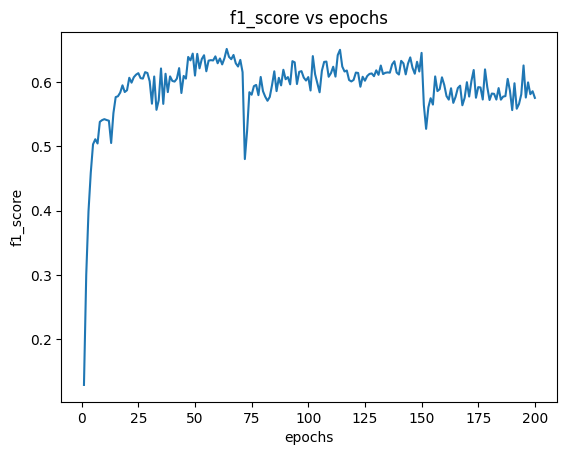

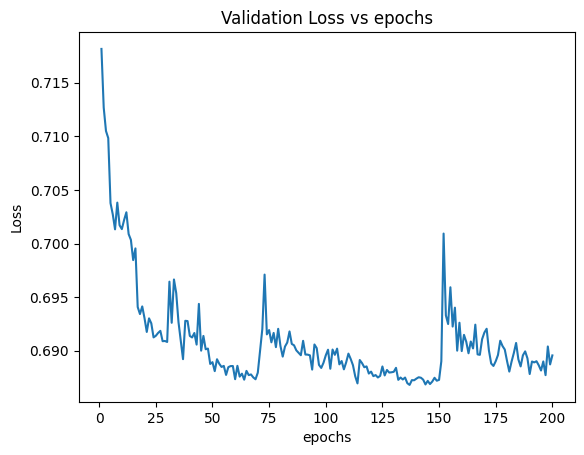

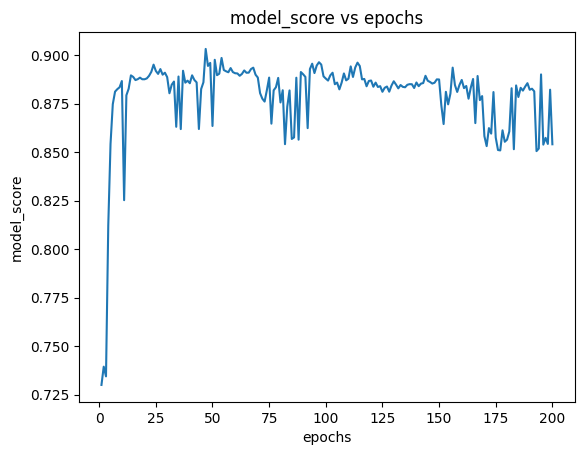

In [7]:
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,201), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,201), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Validation Loss vs epochs')

plt.figure(3)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,201), model_arr)
plt.xlabel("epochs")
plt.ylabel("model_score")
plt.title('model_score vs epochs')

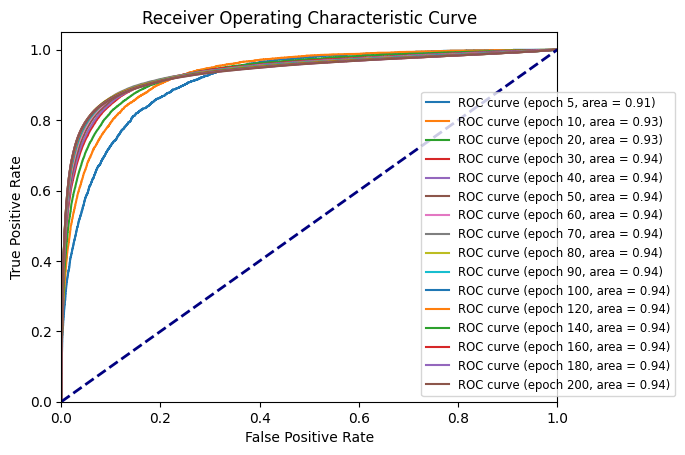

: 

In [8]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)